# COMS-E6998-010: Homework 5 {-}
__Name:__ Nicholas Christman (n2677)
__Due:__ Dec. 10, 2020

In [4]:
from __future__ import print_function, division

import sys
import time
import os
import shutil
import random
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from pprint import pprint
# from IPython.display import display,SVG,HTML,IFrame,Image
import IPython.display as ipd
from PIL import Image

import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

from scipy.optimize import curve_fit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# set global seed
seed = 6998
torch.manual_seed(seed)
random.seed(seed)

# helper function so that images are exportable to PDF
def inlineImage(url,title='',size=(8,8)):
    plt.figure(figsize=size)
    plt.imshow(Image.open(url))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [101]:
# use a GPU if there is one available
cuda_availability = torch.cuda.is_available()
if cuda_availability:
    device = torch.device('cuda:{}'.format(torch.cuda.current_device()))
else:
    device = 'cpu'
print('GPU Available: {}'.format(cuda_availability))
print('Current Device: {}\n\n'.format(device))
# display the GPU info
if cuda_availability:
    !nvidia-smi

GPU Available: True
Current Device: cuda:0


Wed Dec  9 20:54:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     8W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                               

***
## Problem 1 - SSD, ONNX model, Visualization, Inferencing (35) {-}
Following the github repo and ONNX tutorials (links provided below), start with a pretrained Pytorch SSD model and retrain it for your target categories, convert the Pytorch model to ONNX, and then deploy it on ONNX runtime server for inferencing.

For part 1, 2, and 3, refer to the steps in the github repo. For part 4 refer to ONNX tutorial on visualizing and for 5 and 6 refer to ONNX tutorial on inferencing.  

_References:_   

* Github repo. Shot MultiBox Detector Implementation in Pytorch.    
Available at https://github.com/qfgaohao/pytorch-ssd   

* ONNX tutorial. Visualizing an ONNX Model.   
Available at https://github.com/onnx/tutorials/blob/master/tutorials/VisualizingAModel.md   

* ONNX tutorial. Inferencing SSD ONNX model using ONNX Runtime Server.   
Available at https://github.com/onnx/tutorials/blob/master/tutorials/OnnxRuntimeServerSSDModel.ipynb   

* Google. Open Images Dataset V5 + Extensions.   
Available at https://storage.googleapis.com/openimages/web/index.html   

* The PASCAL Visual Object Classes Challenge 2007.   
Available at http://host.robots.ox.ac.uk/pascal/VOC/voc2007/

### 1.1  Pretrained MobilenetV1 SSD tested locally with  Pascal VOC 2007 dataset (show the test accuracy for the 20 classes) {-}

In [24]:
# getting the trainval data
# UNCOMMENT TO RE-RUN
# ! wget -P data/trainval http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
# ! tar -xf data/trainval/VOCtrainval_06-Nov-2007.tar -C data/trainval

In [25]:
# getting the  test data 
# UNCOMMENT TO RE-RUN
# ! wget -P data/test http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
# ! tar -xf data/test/VOCtest_06-Nov-2007.tar -C data/test 

In [26]:
# getting the model/labels
# UNCOMMENT TO RE-RUN
# ! wget -P models https://storage.googleapis.com/models-hao/mobilenet-v1-ssd-mp-0_675.pth
# ! wget -P models https://storage.googleapis.com/models-hao/voc-model-labels.txt

--2020-12-06 23:58:45--  https://storage.googleapis.com/models-hao/mobilenet-v1-ssd-mp-0_675.pth
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 172.253.117.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37995286 (36M) [application/octet-stream]
Saving to: ‘models/mobilenet-v1-ssd-mp-0_675.pth.1’

mobilenet-v1-ssd-mp 100%[===================>]  36.23M   101MB/s    in 0.4s    

2020-12-06 23:58:46 (101 MB/s) - ‘models/mobilenet-v1-ssd-mp-0_675.pth.1’ saved [37995286/37995286]

--2020-12-06 23:58:46--  https://storage.googleapis.com/models-hao/voc-model-labels.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 108.177.98.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145 [text/

In [27]:
# test model with Pascal VOC 2007 dataset
# UNCOMMENT TO RE-RUN
# ! python pytorch-ssd/eval_ssd.py --net mb1-ssd \
# --dataset data/test/VOCdevkit/VOC2007/ \
# --trained_model models/mobilenet-v1-ssd-mp-0_675.pth \
# --label_file models/voc-model-labels.txt
# --trained_model pytorch-ssd/models/mobilenet-v1-ssd-mp-0_675.pth \
# --label_file pytorch-ssd/models/voc-model-labels.txt

_Note: this is a snippet from the actual output._

```
pytorch-ssd/eval_ssd.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt_boxes[class_index][image_id] = torch.tensor(all_gt_boxes[class_index][image_id])
It took 0.0654754638671875 seconds to load the model.
process image 0
Load Image: 0.025498 seconds.
Inference time:  0.8003177642822266
Prediction: 0.859447 seconds.
process image 1
Load Image: 0.004779 seconds.
Inference time:  0.007477521896362305
Prediction: 0.059341 seconds.
...
process image 4950
Load Image: 0.004848 seconds.
Inference time:  0.005615711212158203
Prediction: 0.037452 seconds.
process image 4951
Load Image: 0.005250 seconds.
Inference time:  0.005333900451660156
Prediction: 0.039187 seconds.


Average Precision Per-class:
aeroplane: 0.6742489426027927
bicycle: 0.7913672875238116
bird: 0.612096015101108
boat: 0.5616402776942253
bottle: 0.3471256662634949
bus: 0.7742298893362103
car: 0.7284171192326804
cat: 0.8360675520354323
chair: 0.5142295855384792
cow: 0.6244090341627014
diningtable: 0.7060035669312754
dog: 0.7849252606216821
horse: 0.8202146617282785
motorbike: 0.793578272243471
person: 0.7042670984734087
pottedplant: 0.40257147509774405
sheep: 0.6071252282334352
sofa: 0.7549120254763918
train: 0.8270992920206008
tvmonitor: 0.6459903029666852

Average Precision Across All Classes:0.6755259276641954
```

#### Answer: 
The test accuracy for all 20 classes are shown above, with an average precision of 67.6% across all classes.

### 1.2  Select two related categories from Google Open Images and finetune the pretrained SSD model. {-}

* Use _open_images_downloader.py_ script. 
* Use the same parameters that are used in the tutorial.

In [108]:
# select the target categories
cat1 = 'Beer'#'Human eye'#'Beer'#'Pomegranate'#'Traffic light' #'Tree'
cat2 = 'Bottle'#'Human mouth'#'Bottle'#'Apple'#'Traffic sign' #'Christmas Tree'
class_names = f"\"{cat1}, {cat2}\""
root = 'data/open_images'
# image directories (in case needed)
train_images = f'{root}/training'
val_images = f'{root}/validation'
test_images = f'{root}/test' #used for drawing box

class_names

'"Beer, Bottle"'

In [29]:
# getting the Google Open Image data
# UNCOMMENT TO RE-RUN (note: delete old open-images dir!)
# ! python pytorch-ssd/open_images_downloader.py --root $root \
#                                                --class_names $class_names \
#                                                --num_workers 20

```
2020-12-06 07:13:34,486 - root - Download https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv.
2020-12-06 07:13:34,572 - root - Download https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv.
2020-12-06 07:13:55,913 - root - Read annotation file data/open_images/train-annotations-bbox.csv
2020-12-06 07:14:09,783 - root - train bounding boxes size: 49753
2020-12-06 07:14:09,783 - root - Approximate Image Stats: 
2020-12-06 07:14:09,799 - root - Bottle: 11456/16117 = 0.71.
2020-12-06 07:14:09,799 - root - Beer: 4661/16117 = 0.29.
2020-12-06 07:14:09,799 - root - Label distribution: 
2020-12-06 07:14:09,804 - root - Bottle: 40188/49753 = 0.81.
2020-12-06 07:14:09,804 - root - Beer: 9565/49753 = 0.19.
2020-12-06 07:14:09,804 - root - Shuffle dataset.
2020-12-06 07:14:09,804 - root - Save train data to data/open_images/sub-train-annotations-bbox.csv.
2020-12-06 07:14:10,192 - root - Download https://storage.googleapis.com/openimages/2018_04/validation/validation-annotations-bbox.csv.
2020-12-06 07:14:10,473 - root - Read annotation file data/open_images/validation-annotations-bbox.csv
2020-12-06 07:14:10,704 - root - validation bounding boxes size: 458
2020-12-06 07:14:10,704 - root - Approximate Image Stats: 
2020-12-06 07:14:10,707 - root - Bottle: 177/260 = 0.68.
2020-12-06 07:14:10,707 - root - Beer: 83/260 = 0.32.
2020-12-06 07:14:10,707 - root - Label distribution: 
2020-12-06 07:14:10,707 - root - Bottle: 340/458 = 0.74.
2020-12-06 07:14:10,708 - root - Beer: 118/458 = 0.26.
2020-12-06 07:14:10,708 - root - Shuffle dataset.
2020-12-06 07:14:10,708 - root - Save validation data to data/open_images/sub-validation-annotations-bbox.csv.
2020-12-06 07:14:10,712 - root - Download https://storage.googleapis.com/openimages/2018_04/test/test-annotations-bbox.csv.
2020-12-06 07:14:11,620 - root - Read annotation file data/open_images/test-annotations-bbox.csv
2020-12-06 07:14:12,263 - root - test bounding boxes size: 1311
2020-12-06 07:14:12,263 - root - Approximate Image Stats: 
2020-12-06 07:14:12,266 - root - Bottle: 533/741 = 0.72.
2020-12-06 07:14:12,266 - root - Beer: 208/741 = 0.28.
2020-12-06 07:14:12,266 - root - Label distribution: 
2020-12-06 07:14:12,267 - root - Bottle: 979/1311 = 0.75.
2020-12-06 07:14:12,267 - root - Beer: 332/1311 = 0.25.
2020-12-06 07:14:12,267 - root - Shuffle dataset.
2020-12-06 07:14:12,267 - root - Save test data to data/open_images/sub-test-annotations-bbox.csv.
2020-12-06 07:14:12,278 - root - Start downloading 15074 images.
2020-12-06 07:14:14,487 - root - Downloaded 100 images.

...   

2020-12-06 07:17:10,716 - root - Downloaded 15000 images.
2020-12-06 07:17:13,589 - root - Task Done.
```

### Accuracy before & after finetuning {-}
To finetune the source model, I chose to increase the batch size from the default (5 images) up to 8 images to improve the performance. All other parameters were left as the default. We used the open_images dataset type with the two categories "Beer" and "Bottle" as the targets for training.   

#### Answer: {-}   

* __Before:__   
The accuracy before finetuning was captured by training with the pretrained model for 1 epoch so to produce the correct output dimensions, and and then evaluate the new (1 epoch) model (this gets us close to what we would see from the original model). Refer to Piazza @349. This "1 epoch" model is saved by default during training. As can be seen below (before the finetuning portion), the average precision for the 'Beer' class before finetuning was 60.1%  and, likewise, the 'Bottle' class was 41.0%. Overall, the average precision for all a classes was 50.6%.  

* __After:__   
Furthermore, also shown below, the average precision for the 'Beer' class after finetuning was 71.2% (\~12% improvement) and, likewise, the 'Bottle' class was 56.1% (\~15% improvement). Overall, the average precision for all a classes was 63.7% (\~13% improvement). 

In [31]:
#Finetune the model. Use the model saved at Epoch 0 for the "before" finetuning accuracy and 
# the model saved at Epcoh 99 for the "after" finetuning accuracy.
# NOTE: I had to run this from the terminal on this GCP... it was not showing console output
#       correctly when ran in the Jupyter cell
# UNCOMMENT TO TRAIN
# ! python pytorch-ssd/train_ssd.py --dataset_type open_images \
#                       --datasets data/open_images \
#                       --net mb1-ssd \
#                       --pretrained_ssd models/mobilenet-v1-ssd-mp-0_675.pth \
#                       --use_cuda True \
#                       --scheduler cosine \
#                       --lr 0.01 \
#                       --t_max 100 \
#                       --validation_epochs 5 \
#                       --num_epochs 100 \
#                       --base_net_lr 0.001 \
#                       --batch_size 8

_Note: this is a snippet from the terminal console output..._
```
(base) jupyter@pytorch-tesla-notebook-instance:~/comse6998-hw5$  python pytorch-ssd/train_ssd.py --dataset_type open_images --datasets data/open_images --net mb1-ssd --pretrained_ssd models/mobilenet-v1-ssd-mp-0_675.pth --use_cuda True --scheduler cosine --lr 0.01 --t_max 100 --validation_epochs 5 --num_epochs 100 --base_net_lr 0.001 --batch_size 8
2020-12-06 13:47:04,924 - root - INFO - Use Cuda.
2020-12-06 13:47:04,924 - root - INFO - Namespace(balance_data=False, base_net=None, base_net_lr=0.001, batch_size=8, checkpoint_folder='models/', dataset_type='open_images', datasets=['data/open_images'], debug_steps=100, extra_layers_lr=None, freeze_base_net=False, freeze_net=False, gamma=0.1, last_epoch=None, lr=0.01, mb2_width_mult=1.0, milestones='80,100', momentum=0.9, net='mb1-ssd', num_epochs=100, num_workers=4, pretrained_ssd='models/mobilenet-v1-ssd-mp-0_675.pth', resume=None, scheduler='cosine', t_max=100.0, use_cuda=True, validation_dataset=None, validation_epochs=5, weight_decay=0.0005)
2020-12-06 13:47:04,926 - root - INFO - Prepare training datasets.
2020-12-06 13:47:14,001 - root - INFO - Dataset Summary:Number of Images: 14147
Minimum Number of Images for a Class: -1
Label Distribution:
        Beer: 9565
        Bottle: 40188
2020-12-06 13:47:14,025 - root - INFO - Stored labels into file models/open-images-model-labels.txt.
2020-12-06 13:47:14,025 - root - INFO - Train dataset size: 14147
2020-12-06 13:47:14,026 - root - INFO - Prepare Validation datasets.
2020-12-06 13:47:14,462 - root - INFO - Dataset Summary:Number of Images: 685
Minimum Number of Images for a Class: -1
Label Distribution:
        Beer: 332
        Bottle: 979
2020-12-06 13:47:14,463 - root - INFO - validation dataset size: 685
2020-12-06 13:47:14,463 - root - INFO - Build network.
2020-12-06 13:47:14,528 - root - INFO - Init from pretrained ssd models/mobilenet-v1-ssd-mp-0_675.pth
2020-12-06 13:47:14,572 - root - INFO - Took 0.04 seconds to load the model.
2020-12-06 13:47:17,601 - root - INFO - Learning rate: 0.01, Base net learning rate: 0.001, Extra Layers learning rate: 0.01.
2020-12-06 13:47:17,602 - root - INFO - Uses CosineAnnealingLR scheduler.
2020-12-06 13:47:17,602 - root - INFO - Start training from epoch 0.
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
2020-12-06 13:47:48,097 - root - INFO - Epoch: 0, Step: 100, Average Loss: 6.2111, Average Regression Loss 2.6708, Average Classification Loss: 3.5403
...
2020-12-06 22:12:52,448 - root - INFO - Epoch: 99, Step: 1600, Average Loss: 2.6800, Average Regression Loss 0.8794, Average Classification Loss: 1.8006
2020-12-06 22:13:22,399 - root - INFO - Epoch: 99, Step: 1700, Average Loss: 2.7012, Average Regression Loss 0.8862, Average Classification Loss: 1.8149
2020-12-06 22:13:41,567 - root - INFO - Trained 99.
2020-12-06 22:13:51,702 - root - INFO - Epoch: 99, Validation Loss: 2.4403, Validation Regression Loss 0.6052, Validation Classification Loss: 1.8351
2020-12-06 22:13:51,738 - root - INFO - Saved model models/mb1-ssd-Epoch-99-Loss-2.440300151359203.pth
```

#### Before finetuning accuracy {-}

In [109]:
labels_txt = 'models/open-images-model-labels.txt'
model_before = 'models/mb1-ssd-Epoch-0-Loss-3.3745224586752958.pth' # <-- update as needed!
if os.path.isfile(model_before):
    new_model_before = 'models/mb1-ssd-before.pth'
    shutil.copy(model_before,new_model_before)  # <-- renamed for clarity!
    print(f'\'{model_before}\' copied to \'{new_model_before}\'!')
    model_before = new_model_before
else:
    print(f'WARNING: \'{model_before}\' does not exist. Please make sure you have the right path.')

# test model with open images dataset and choosen class labels
# UNCOMMENT TO RUN EVALUATION
# ! python pytorch-ssd/eval_ssd.py --dataset_type open_images \
#                                 --net mb1-ssd \
#                                 --dataset $root \
#                                 --trained_model $model_before \
#                                 --label_file $labels_txt

_Note: for brevity, this is a snippet of the actual (full) result._
```
'models/mb1-ssd-Epoch-0-Loss-3.3745224586752958.pth' copied to 'models/mb1-ssd-before.pth'!
pytorch-ssd/eval_ssd.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt_boxes[class_index][image_id] = torch.tensor(all_gt_boxes[class_index][image_id])
It took 0.04972076416015625 seconds to load the model.
process image 0
Load Image: 0.017154 seconds.
Inference time:  0.347855806350708
Prediction: 0.376159 seconds.
...
process image 684
Load Image: 0.020438 seconds.
Inference time:  0.00860142707824707
Prediction: 0.035581 seconds.


Average Precision Per-class:
Beer: 0.6013311153375451
Bottle: 0.40987783953453927

Average Precision Across All Classes:0.5056044774360422
```

#### After finetuning accuracy {-}

In [110]:
model_after = 'models/mb1-ssd-Epoch-99-Loss-2.440300151359203.pth' # <-- update as needed!
if os.path.isfile(model_after):
    new_model_after = 'models/mb1-ssd-after.pth'
    shutil.copy(model_after,new_model_after)  # <-- renamed for clarity!
    print(f'\'{model_after}\' copied to \'{new_model_after}\'!')
    model_after = new_model_after
else:
    print(f'WARNING: \'{model_after}\' does not exist. Please make sure you have the right path.')

# test model with open images dataset and choosen class labels
# UNCOMMENT TO RUN EVALUATION
# print(f'--> {model_after}')
# ! python pytorch-ssd/eval_ssd.py --dataset_type open_images \
#                                 --net mb1-ssd \
#                                 --dataset $root \
#                                 --trained_model $model_after \
#                                 --label_file $labels_txt

_Note: this is a snippet from the terminal console output..._

```
'models/mb1-ssd-Epoch-99-Loss-2.440300151359203.pth' copied to 'models/mb1-ssd-after.pth'!
pytorch-ssd/eval_ssd.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt_boxes[class_index][image_id] = torch.tensor(all_gt_boxes[class_index][image_id])
It took 0.05119943618774414 seconds to load the model.
process image 0
Load Image: 0.024406 seconds.
Inference time:  0.4122161865234375
Prediction: 0.436297 seconds.

...   


process image 684
Load Image: 0.012734 seconds.
Inference time:  0.0065114498138427734
Prediction: 0.035629 seconds.


Average Precision Per-class:
Beer: 0.7117299231385192
Bottle: 0.5614316991981058

Average Precision Across All Classes:0.6365808111683124
```

### 1.3  Convert the Pytorch model to ONNX format and save it. {-}
Per the reference below, some additional considerations are needed. First, the included `convert_to_caffe2_models.py` defines the model output_names as `scores` and `boxes`; however, ssd-mobilenetv1 appears to have outputs of `num_detections` (the number of detections), `detection_boxes` (a list of bounding boxes), `detection_scores` (the score for each detection), and `detection_classes` (an array of 10 integers). To overcome this difference, we will use a workaround to collect the labels after inference.

ref: https://github.com/onnx/models/tree/master/vision/object_detection_segmentation/ssd-mobilenetv1

In [48]:
print(f'Model exists: {os.path.isfile(model_after)}')
print(f'Labels exist: {os.path.isfile(labels_txt)}')

# some considerations are made since we are using mb1-ssd, which appears to have different outputs 
# than what are defined in the included 'convert'
# in the 

# convert the models to ONNX format
# Note: I modified convert_to_caffe2_models.py so that cuda could be used
! python pytorch-ssd/convert_to_caffe2_models.py mb1-ssd $model_after $labels_txt 
# WARNING: an unresolved error occurs (as shown below), but the ONNX file is still produced

Model exists: True
Labels exist: True
All further enhancements and fixes to optimizers will be done in this new repo.
The optimizer code in onnx/onnx repo will be removed in 1.9 release.

Traceback (most recent call last):
  File "pytorch-ssd/convert_to_caffe2_models.py", line 62, in <module>
    init_net, predict_net = c2.onnx_graph_to_caffe2_net(model)
  File "/opt/conda/lib/python3.7/site-packages/caffe2/python/onnx/backend.py", line 921, in onnx_graph_to_caffe2_net
    return cls._onnx_model_to_caffe2_net(model, device=device, opset_version=opset_version, include_initializers=True)
  File "/opt/conda/lib/python3.7/site-packages/caffe2/python/onnx/backend.py", line 876, in _onnx_model_to_caffe2_net
    onnx_model = onnx.utils.polish_model(onnx_model)
  File "/opt/conda/lib/python3.7/site-packages/onnx/utils.py", line 24, in polish_model
    model = onnx.optimizer.optimize(model)
  File "/opt/conda/lib/python3.7/site-packages/onnx/optimizer.py", line 55, in optimize
    optimized_mod

#### Answer:
As shown above, we are receiving an error during conversion that the `base_net.0.0.weight` is undefined. After visualizing the model (below) we can see that this is an expected input to the network. Unless I have time to resolve this later, as of right now it is unclear why this input is undefined. Regardless of the error, it does appear that the ONNX file is still produced so we can proceed.

### 1.4  Visualize the model using net drawer tool {-}
* Compile the model using embed_docstring flag and show the visualization output. 
* Also show doc string (stack trace for PyTorch) for different types of nodes

In [35]:
# install python dependencies
# ! pip install graphviz pydot
# clone ONNX to access net_drawer.py
# ! git clone https://github.com/onnx/onnx.git

In [111]:
# define netdrawer/visualization paths
input_onnx='models/mb1-ssd.onnx'
output_dot='data/onnx_output/mb1-ssd.dot'
output_svg='data/onnx_output/mb1-ssd.svg'
output_png='data/onnx_output/mb1-ssd.png'

In [50]:
# execute net_drawer
! python onnx/onnx/tools/net_drawer.py --input $input_onnx --output $output_dot --embed_docstring

# create visualization of the network
! dot -Tsvg $output_dot -o $output_svg
! dot -Tpng $output_dot -o $output_png

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.590833 to fit


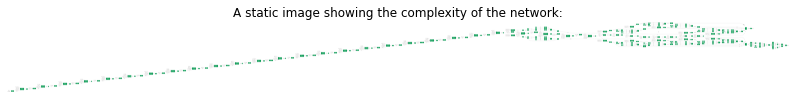

In [317]:
# dsiplay the network using an Iframe to make it interactive
output_svg_name = os.path.basename(output_svg)

# Add a link to the  SVG
ipd.display(ipd.HTML("""A link to the SVG: <a href="{}">
                Open {} in new tab!</a><br/>""".format(output_svg,output_svg_name)))
# show the SVG in an IFrame
# ipd.display(ipd.HTML("""<H2>A scrollable IFrame showing the full network SVG:</H2>"""))
# ipd.display(ipd.HTML("""<iframe id="if" width="850" height="400" src={} frameborder="0"></iframe>""".format(svg_path)))

# show the whole network using Python so it exports to PDF
tmp_img = Image.open(output_png)
plt.figure(figsize=(14,14))
plt.imshow(tmp_img)
plt.title(f'A static image showing the complexity of the network:')
plt.axis('off')
plt.show()

__Answer:__ As can be seen above, the network is quite complex. An attempt was made to show parts of the network in addition to the entire network (see below for some snippets). The embedded doc_strings appear to be enabled (as shown below), but none of the ops nodes seemed to have any useful information -- I tried to click on a couple dozen different nodes from the input through to the output and all of them produced an empty alert as shown below.

<!-- Removed Markdown embedded image because they don't seem to print in PDF -->
<!-- <img src="q1_showing-docstring-empty.PNG" 
     style="width:700px;  border: 5px solid black;"
     alt="Showing Empty Doc-String" />   
      -->

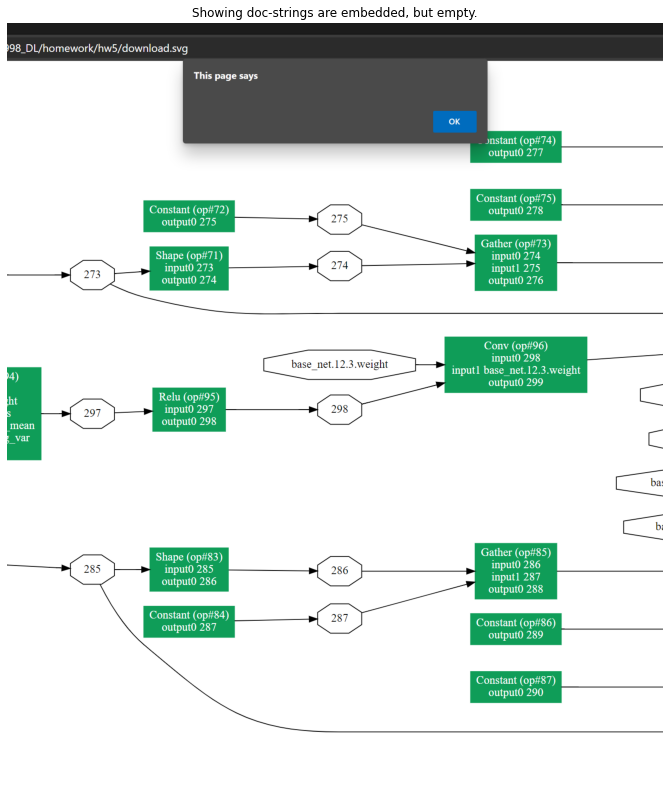

In [74]:
inlineImage('content/q1_showing-docstring-empty.PNG',
            title='Showing doc-strings are embedded, but empty.',
            size=(14,14))

     
After exploring the network graphic, it can be seen that the expected input (for later) is "input.1". 
<!-- <div style="float: left; padding: 10px;">
  <img src="q1_input-input.PNG" 
     style="height:180px;  border: 5px solid black;"
     alt="scores output" />   
</div> -->

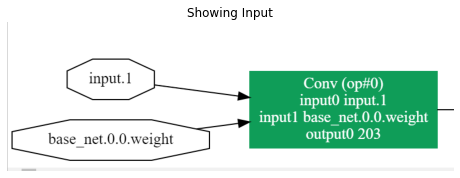

In [104]:
inlineImage('content/q1_input-input.PNG',
            title='Showing Input')

Similarly, it can be seen that the expected outputs (for later) are "scores" and "boxes". 
<!-- <div class="row">
  <div style="float: left; width: 33.33%;padding: 10px;">
    <img src="q1_output-boxes.PNG" 
     style="height:200px;  border: 5px solid black;"
     alt="boxes output" /> 
  </div>
  <div style="float: left; width: 33.33%;padding: 10px;">
    <img src="q1_output-scores.PNG" 
     style="height:200px;  border: 5px solid black;"
     alt="scores output" />   
  </div>
</div> -->

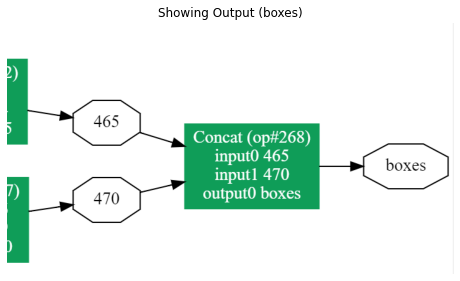

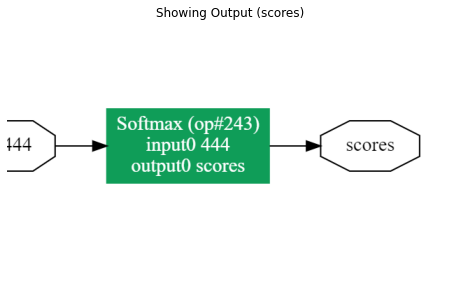

In [77]:
inlineImage('content/q1_output-boxes.PNG',
            title='Showing Output (boxes)')
inlineImage('content/q1_output-scores.PNG',
            title='Showing Output (scores)')

### 1.5 Deploy the ONNX model on ONNX runtime (ORT) server. {-}
* Set up the environment following steps listed in the tutorial. 
* Then make HTTP request to the ORT server. 
* Test the inferencing set-up using 1 image from each of the two selected categories. 

In [112]:
import assets.onnx_ml_pb2 as onnx_ml_pb2
import assets.predict_pb2 as predict_pb2

In [53]:
# from the ONNX inferencing tutorial refrenced above
# download the ONNXRuntmie Server image
# UNCOMMENT TO RE-DOWNLOAD CONTAINER
# ! sudo docker pull mcr.microsoft.com/onnxruntime/server

In [116]:
PORT_NUMBER = 9001
# start the docker container
! echo 'Loading model {input_onnx}'
! echo
# UNCOMMENT TO START DOCKER CONTAINER
# ! sudo docker run -it -v $(pwd):$(pwd) -p $PORT_NUMBER:8001 mcr.microsoft.com/onnxruntime/server --model_path $(pwd)/$input_onnx
# UNCOMMENT TO STOP DOCKER <CONTAINER ID>
# ! docker stop 6469b5de2391                                                
! docker ps

Loading model models/mb1-ssd.onnx

CONTAINER ID        IMAGE                                  COMMAND                  CREATED             STATUS              PORTS                    NAMES
7e538545dbe7        mcr.microsoft.com/onnxruntime/server   "/onnxruntime/server…"   14 seconds ago      Up 14 seconds       0.0.0.0:9001->8001/tcp   beautiful_hamilton
c3d71876798a        gcr.io/inverting-proxy/agent           "/bin/sh -c '/opt/bi…"   9 hours ago         Up 9 hours                                   proxy-agent


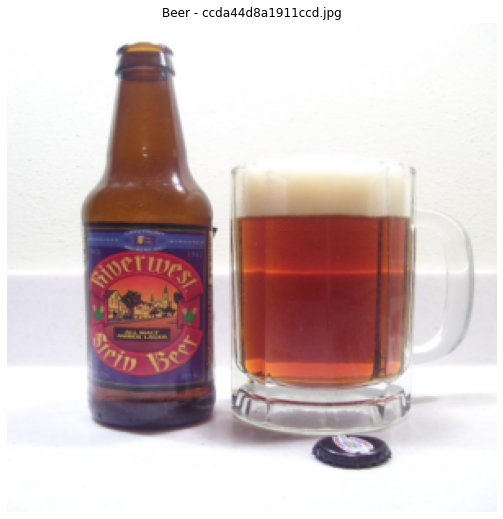

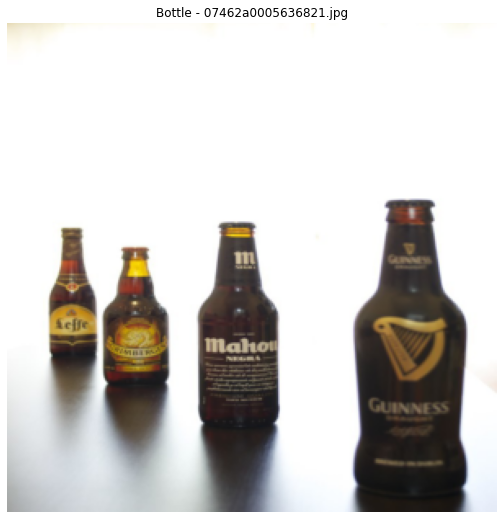

In [305]:
RANDOM_IMAGES = False
SEED = 698
root = 'data/open_images_beer'
test_images = 'data/open_images_beer/test'
# path to test images
# image_path = ''#'data/trainval/open_images/test'
# load the label and test annotation metadata
class_desc = pd.read_csv(f'{root}/class-descriptions-boxable.csv',names=['LabelName','Category'])
test_ann = pd.read_csv(f'{root}/test-annotations-bbox.csv')
test_ann = test_ann[['ImageID','LabelName']]

if(RANDOM_IMAGES):
    # get the labels based on the categories
    cat1_label = class_desc.loc[class_desc['Category'] == cat1, 'LabelName'].item()
    cat2_label = class_desc.loc[class_desc['Category'] == cat2, 'LabelName'].item()


    # get the image names based on the label names
    cat1_images = list(test_ann.loc[test_ann['LabelName'] == cat1_label, 'ImageID'])
    cat2_images = list(test_ann.loc[test_ann['LabelName'] == cat2_label, 'ImageID'])

    # randomly select one image from each category
    np.random.seed(SEED)
    img1_name = np.random.choice(cat1_images,1)[0]
    img2_name = np.random.choice(cat2_images,1)[0]
else:
    # manually define image names
    img1_name = 'ccda44d8a1911ccd'
    img2_name = '07462a0005636821'

# image from 1st category
cat1_image = f'{test_images}/{img1_name}.jpg'
img1 = Image.open(cat1_image)
# image from 2nd category
cat2_image = f'{test_images}/{img2_name}.jpg'
img2 = Image.open(cat2_image)
# we need to resize each of the images to meet the requirements
# of the SSD model.
img1 = img1.resize((300, 300), Image.BILINEAR)
img2 = img2.resize((300, 300), Image.BILINEAR)

# show the image of each category
plt.figure(figsize=(12,9))
plt.imshow(img1)

plt.title(f'{cat1} - {img1_name}.jpg')
plt.axis('off')
plt.show()
plt.figure(figsize=(12,9))
plt.imshow(img2)
plt.title(f'{cat2} - {img2_name}.jpg')
plt.axis('off')
plt.show()

# for inferencing
imgs = [img1,img2]

In [306]:
def inferenceRequest(img):
    # Preprocess and normalize the image (same as the tutorial)
    print('\r[request] Preprcessing the image...',end='')
    img_data = np.array(img)
    img_data = np.transpose(img_data, [2, 0, 1])
    img_data = np.expand_dims(img_data, 0)
    mean_vec = np.array([0.485, 0.456, 0.406])
    stddev_vec = np.array([0.229, 0.224, 0.225])
    norm_img_data = np.zeros(img_data.shape).astype('float32')
    for i in range(img_data.shape[1]):
        norm_img_data[:,i,:,:] = (img_data[:,i,:,:]/255 - mean_vec[i]) / stddev_vec[i]
    print('done')

    # Create request message to be sent to the ORT server (same as tutorial)
    print('\r[request] Creating the prediction request messsage...',end='')
    input_tensor = onnx_ml_pb2.TensorProto()
    input_tensor.dims.extend(norm_img_data.shape)
    # input_tensor.dims.extend(img_data.shape)
    input_tensor.data_type = 1
    input_tensor.raw_data = norm_img_data.tobytes()
    # input_tensor.raw_data = img_data.tobytes()
    # prediction request
    request_message = predict_pb2.PredictRequest()
    # For your model, the inputs name should be something else customized by yourself. 
    # nc2677: from above, we discovered that the input is actually 'input.1'
    request_message.inputs["input.1"].data_type = input_tensor.data_type
    request_message.inputs["input.1"].dims.extend(input_tensor.dims)
    request_message.inputs["input.1"].raw_data = input_tensor.raw_data
    # content header list
    content_type_headers = ['application/x-protobuf', 'application/octet-stream', 'application/vnd.google.protobuf']
    for h in content_type_headers:
        request_headers = {
            'Content-Type': h,
            'Accept': 'application/x-protobuf'
        }
    print('done')

    # send request    
    print('\r[request] Sending the prediction request message...',end='')
    # Inference run using ORT server (update port number according to the docker settings above)
    # PORT_NUMBER = 9001 #nc2677: set above
    inference_url = f"http://127.0.0.1:{PORT_NUMBER}/v1/models/default/versions/1:predict"
    response = requests.post(inference_url, 
                         headers=request_headers, 
                         data=request_message.SerializeToString())
    print('done')
    print()

    # return the response
    return response
    
def inferenceResponse(response):
    #Parse response message (same as tutorial)
    print('\r[response] Retrieving the prediction response message...',end='')
    response_message = predict_pb2.PredictResponse()
    print('done')
    print('\r[response] Parsing the resonse message...',end='')
    response_message.ParseFromString(response.content)
    print('done')

    # For your model, the outputs names should be something else customized by yourself. 
    # Use Netron to find out the outputs names.
    print('\r[response] Collecting the predicted outputs...',end='')
    bboxes = np.frombuffer(response_message.outputs['boxes'].raw_data, dtype=np.float32)
    scores = np.frombuffer(response_message.outputs['scores'].raw_data, dtype=np.float32)
    # for some reason, labels are not inferred? Added workaround per Piazza @374
    # labels = np.frombuffer(response_message.outputs['labels'].raw_data, dtype=np.int64)
    labels = np.argmax(scores.reshape((3000, 3)), axis=1)
    print('done')
    # display some results
    print('[response] Boxes shape:', response_message.outputs['boxes'].dims)
    print('[response] Scores shape:', response_message.outputs['scores'].dims)
    print('[response] Labels shape:', labels.shape)
    # return the outputs
    return bboxes,scores,labels

# demonstrate the ORT server
response = inferenceRequest(img)

[request] Preprcessing the image...done
[request] Creating the prediction request messsage...done
[request] Sending the prediction request message...done



__Answer:__ the ONNX runtime server was successfully created in this problem and the inferencing process was completed using the tutorial for each step. I've displayed the two images above and went through each of the tutorial steps to make sure the image was put in the proper format for inferencing. Now it is time to parse the response from the ORT server.

### 1.6 Parse the response message from the ORT server and annotate the two images. {-}
* Show inferencing output (bounding boxes with labels) for the two images. 

Sending the prediction request to ORT for model 'mb1-ssd'
[request] Preprcessing the image...done
[request] Creating the prediction request messsage...done
[request] Sending the prediction request message...done

[response] Retrieving the prediction response message...done
[response] Parsing the resonse message...done
[response] Collecting the predicted outputs...done
[response] Boxes shape: [1, 3000, 4]
[response] Scores shape: [1, 3000, 3]
[response] Labels shape: (3000,)


<Figure size 432x288 with 0 Axes>

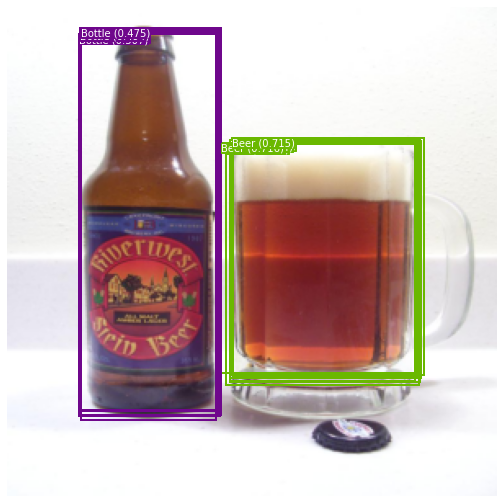

Sending the prediction request to ORT for model 'mb1-ssd'
[request] Preprcessing the image...done
[request] Creating the prediction request messsage...done
[request] Sending the prediction request message...done

[response] Retrieving the prediction response message...done
[response] Parsing the resonse message...done
[response] Collecting the predicted outputs...done
[response] Boxes shape: [1, 3000, 4]
[response] Scores shape: [1, 3000, 3]
[response] Labels shape: (3000,)


<Figure size 432x288 with 0 Axes>

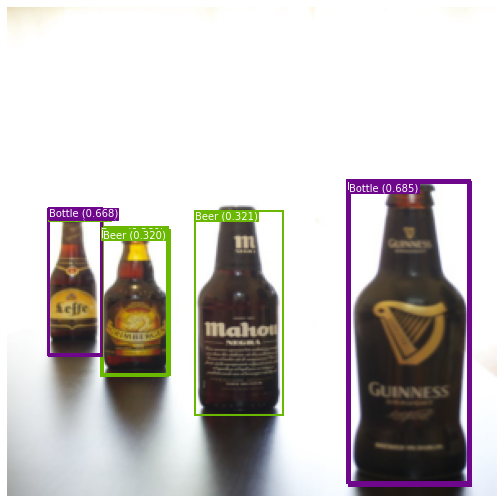

In [307]:
# helper function to generate RGB floats
def randomColor(seed=None):
    if seed:
        np.random.seed(seed)
    return list(np.random.rand(3))

model_name = os.path.basename(input_onnx).split('.')[0]
for img in imgs:
    print(f'Sending the prediction request to ORT for model \'{model_name}\'')
    # infer
    response = inferenceRequest(img)
    bboxes,scores,labels = inferenceResponse(response)
    # reshape to desired shape
    scores = scores.reshape((3000, 3))
    bboxes = bboxes.reshape((3000, 4))

    # Parse the list of class labels and generate a random color for each class
    classes = [line.rstrip('\n') for line in open('models/open-images-model-labels.txt')]
    rand_color = [randomColor(i) for i,x in enumerate(range(len(classes)))]

    # Plot the bounding boxes on the image
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)

    resized_width = 300  # we resized the original image, remember ? 
    resized_height = 300
    num_boxes = 6 # we limit displaying to just 6 boxes to avoid clogging the result image with boxes
                   # The results are already sorted based on box confidences, so we just pick top N boxes without sorting

    label_count = np.zeros(len(classes))
    for i,label in enumerate(classes):
        # sort scores/bboxes together, descending by score
        sorted_pairs = sorted(zip(scores[:,i], bboxes), key=lambda x: x[0], reverse=True)
        tuples = zip(*sorted_pairs)
        tmp_s, tmp_b = [ list(tuple) for tuple in  tuples]
        # for each score, draw the bbox (up to num_boxes)
        for b,s in zip(tmp_b,tmp_s):
            # skip 'BACKGROUND' and if label count > max
            if (label == 'BACKGROUND' or label_count[i] > num_boxes):
                continue    
            label_count[i] += 1
            # draw the bounding boxes
            base_index = 0 # nc2677: I reshaped the data
            y1, x1, y2, x2 = b[base_index] * resized_height, \
                             b[base_index + 1] * resized_width, \
                             b[base_index + 2] * resized_height, \
                             b[base_index + 3] * resized_width 
            color = rand_color[i]
            box_h = (y2 - y1)
            box_w = (x2 - x1)
            bbox = patches.Rectangle((y1, x1), box_h, box_w, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(bbox)
            text = f'{label} ({s:0.3f})'
            plt.text(y1, x1, s=text, color='white', verticalalignment='top', bbox={'color': color, 'pad': 0})

    plt.axis('off')

    # Save image
    plt.savefig("data/results/mb1-ssd_result.jpg", bbox_inches='tight', pad_inches=0.0)
    plt.show()

#### Answer:
As can be seen above, the model deployed to ORT did a fairly good job predicting the class for each object. I limit number of boxes to 6 per class (i.e., 6 for `Bottle` and 6 for `Beer`) while filtering out the `BACKGROUND` completely. Further more, I sort all scores by descending order (with appropriate bounding boxes) thereby only displaying the top 6 predictions per class. In the first image, the glass of beer appears to have always been classified as `Beer` while the bottle of beer was always classified as `Bottle` -- this is not surprising. The second prediction is interesting because there are no glasses of beer, but instead multiple bottles of beer. The results show that `Beer` was not predicted well (just over 30%) while the `Bottle` class predicted better (just under 70%).

__This concludes Problem 1!__

***
## Problem 2 - ML Cloud Platforms (20) {-}
In this question you will analyze different ML cloud platforms and compare their service offerings. In
particular, you will consider ML cloud offerings from IBM, Google, Microsoft, and Amazon and compare
them on the basis of following criteria:

### 2.1 Frameworks {-}
DL framework(s) supported and their version. (_Here we are referring to machine learning platforms which have their own inbuilt images for different frameworks_)


**Note 1: the information below assumes the most recent `platform` release as some frameworks may have been supported in previous `platform` versions but are no longer supported.**   
**Note 2: given the extent of this question, focus was on natively supported frameworks (i.e., frameworks that are listed in a support document) vs. frameworks that "can" be configured (i.e., frameworks that are documented on a blog).**



|Platform|TensorFlow|TensorFlow2|PyTorch|MXNet|Chainer| CNTK| Keras | 
|--------|:--------:|:-----:|:-----:|:-----:|:---:|:-----:|:---:|
|[Amazon](https://docs.aws.amazon.com/dlami/latest/devguide/features.html "AWS DL") | X | X | X | X | X | | X |
|[Google](https://cloud.google.com/ai-platform/deep-learning-vm/docs/images?hl=en_US#listing-versions "GCP DL") | 1.8+ | 2.0+ | 0.4+ | 1.3+ | 4.3+ | 2.7+ | X |
|[IBM](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/pm_service_supported_frameworks.html "IBM DL") | 1.15 | 2.1 | 1.2 | | | | 2.2.5 |
|[Microsoft](https://docs.microsoft.com/en-us/azure/machine-learning/data-science-virtual-machine/dsvm-tools-deep-learning-frameworks "MS Azure DL") | 1.13 | X | 1.2 | 1.3 | 5.2 | 2.5.1 |  2.2.4 |

|Platform|Caffe| Caffe2| Theano| XGBoost | R | Scikit-learn | Spark | 
|--------|:--------:|:-----:|:-----:|:-----:|:---:|:-----:|:---:|
|[Amazon](https://docs.aws.amazon.com/dlami/latest/devguide/features.html "AWS DL") |||||X| X | X |
|[Google](https://cloud.google.com/ai-platform/deep-learning-vm/docs/images?hl=en_US#listing-versions "GCP DL") |X|||0.8+|3.5+| X | X |
|[IBM](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/pm_service_supported_frameworks.html "IBM DL") | X|X||0.8+|| 0.19+ | 2.4 |
|[Microsoft](https://docs.microsoft.com/en-us/azure/machine-learning/data-science-virtual-machine/dsvm-tools-deep-learning-frameworks "MS Azure DL") |X|X|1.0.3|X|| X | X|

### 2.2 Compute units {-}
The type(s) of compute units offered, i.e., GPU types. 

* Amazon [Ref.](https://aws.amazon.com/nvidia/)
   * EC2 P4d instances feature NVIDIA Tesla `A100` GPUs
   * EC2 P3 instances feature NVIDIA Tesla `V100` GPUs
   * EC2 G4 instances feature NVIDIA Tesla `T4` GPUs
* Google: [Ref.](https://cloud.google.com/compute/docs/gpus)
   * Features NVIDIA Tesla `T4`, `V100`, `P100`, `P4`, and `K80` GPUs (availability depends on compute zone)
* IBM: [Ref.](https://www.ibm.com/nl-en/cloud/gpu)
   * Features NVIDIA Tesla `M60`, `K80`, `P100` an `V100` GPUs. 
* Microsoft: [Ref.](https://docs.microsoft.com/en-us/azure/virtual-machines/sizes-gpu)
   * NC T4_v3-series features NVIDIA Tesla `T4` GPU and AMD `EPYC2 Rome` CPU
   * NCv3-series features NVIDIA Tesla `V100` GPU
   * NDv2-series features the Nvidia Volta `V100` GPU and Intel `Xeon Platinum 8168` CPU
   * NV- and NVv3-series feature NVIDIA Tesla `M60` GPU
   * NVv4-series feature AMD Radeon Instinct `MI25` GPU


### 2.3 Model lifecycle management {-} 
Tools supported to manage ML model lifecycle. As can be seen below, each vendor provides sseveral solutions for end-to-end ML model lifecycle management. I personally found Microsoft documentation on this topic to be lacking both depth as well as readability. IBM offered exponentially more resources beyond their well written description of ML lifecycle management. I found Amazon to be the most comprehensive, but detailed information of the available tools was lacking (I was left looking at a diagram to list out the products). 

* Amazon: [Ref.](https://aws.amazon.com/sagemaker/?utm_source=thenewstack&utm_medium=website&utm_campaign=platform#How_it_works)   
Amazon offers many tools that can be leveraged for managing the ML lifecycle; however, Amazon advertises their SageMaker Studio as the end-all solution for full ML lifecycle management. It appears they consider four steps during the ML lifecycle: __prepare__, __build__, __train & tune__, and __deploy & manage__. The Amazon SageMaker platform offers these tools out of the box to support the ML lifecycle: SageMaker Ground Truth, SageMaker Data Wrangler, SageMaker Processing, and SageMaker Features Store (`prepare`); SageMaker Studio/Jupyter Notebooks, Built-in or B.Y.O. Algorithms, Local machine prototyping and SageMaker Autopilot (`build`); One-click training for distributed infrastructure, SageMaker Experiments, Automatic Model Tuning, SageMaker Debugger, and Managed Spot Training to reduce training costs (`train & tune`); and One-Click Deployment, Kubernetes & Kubeflow integration, Multi-Modal endpoints, Model Monitor, and SageMaker Pipelines (`deploy & manage`). 

* Google: [Ref.](https://cloud.google.com/ai-platform)  
Google, like Amazon, offers a plethora of services/products that support the full ML lifecycle and their AI Platform (referenced) is a one-stop-shop for end-to-end ML infrastructure. Google considers four primary steps to the ML lifecycle: __prepare__, __build__, __validate__, and __deploy__. Google offers the following products to support customers through each of the steps: BigQuery, Cloud Storage, and a Data Labeling Service (`prepare`); AutoML, Jupyter Notebooks (on Dataproc or AI Platform), DL Containers, and a Training service (`build`); AI Explanations, a What-if Tool, and Vizier for model tuning (`validate`); and Prediction for hosting a model and AutoML Vision Edge (`deploy`). These products, of course, are supported out of the box by Google but there are also end-less opportunities for users who use Google IaaS/PaaS to spin up their own VM or Kubernetes cluster to accomplish all four of the ML lifecycle steps.

* IBM: [Ref.](https://www.ibm.com/cloud/blog/ai-model-lifecycle-management-overview)  
Per the reference and similar to Google above, IBM also considers four steps in the ML lifecycle: __collect__, __organize__, __analyze__, and __infuse__ (AI models embedded throughout). To cover all steps, IBM provides a comprehensive, integrated data and AI platform known as [Cloud Pak for Data](https://www.ibm.com/products/cloud-pak-for-data). This platform addresses the four steps above with the following tools: data virtualization and data connectors (`collect`); the Watson Knowledge Catalog and Data Refinery (`organize`); the Watson Studio, Watson Machine Learning and Watson OpenScale (`analyze`); and pre-built Watson Assistant, Watson Discovery, Sterling Supply Chain Suite, and Planning Analytics (`infuse`). 

* Microsoft: [Ref.](https://docs.microsoft.com/en-us/azure/machine-learning/concept-model-management-and-deployment)   
Like the others discussed, Microsoft advertises their Azure Machine Learning platform to manage the lifecycle of a ML model. At the core, this platform uses the MLOps approach specifically to provide the following capabilities: creating reproducible ML pipelines, creating reproducible software environment, deploying ML models, collecting governance data of the models, notifycing/alerting on events, monitoring ML applications/issues, and automating the ML lifecycle. To create ML pipelines, the Designer tool can be used. For reusable software environments, Microsoft claims to have a curated environments by default. The Azure Machine Learning environment also supports model registration and tracking by default as well as support for converting models to an open standard (e.g., ONNX); for deployment, Azure Container Instance and Azure Kubernets Service can be leveraged. Tools such as Azure ML Datasets, Interpretability, and Integration with Azure provides support for capturing the governance of data end-to-end lifecycle management.

### 2.4 Monitoring {-} 
availability of application logs and resource (GPU, CPU, memory) usage monitoring data to the user.

* Amazon: [Ref.](https://docs.aws.amazon.com/IAM/latest/UserGuide/security-logging-and-monitoring.html)   
It appears CloudTrail and CloudWatch Logs are services used for logging code/API calls while CloudWatch is used for monitoring resource utilization. In addition, AWS Identity and Access Management Access Analyzer are used for better account access monitoring.

* Google: [Ref.](https://cloud.google.com/products/operations)   
Google use their Cloud operations suite for logging and monitoring (it wasn't that long ago that this was Stackdriver). This operations suite includes tools such as: Cloud Logging (application and system logs), Cloud Monitoring (resource performance, health, etc.), and Cloud Trace/Debugger/Profiler.

* IBM: [Ref.](https://cloud.ibm.com/docs/cli?topic=cli-monitoring_logging)   
By default IBM provides their IBM Cloud Monitoring with Sysdig service to collect and display resource utilization and health metrics. In addition, the IBM Cloud Log Analysis with LogDNA service collects and displays logs for applications and computer runtimes.

* Microsoft: [Ref.](https://azure.microsoft.com/en-us/services/monitor/)   
Microsoft provides their Azure Monitor service to "collect, analyze and act on telemetry data." This includes application monitoring (logs, live metrics, etc.), infrastructure monitoring (logs, CPU, GPU, etc., utilization), network monitoring. It appears this service covers both logging and monitoring.  


### 2.5 Visualization during training {-} 
performance metrics like accuracy and throughput.

* Amazon: [Ref.](https://docs.aws.amazon.com/wellarchitected/latest/machine-learning-lens/data-visualization-and-analytics.html)   
Amazon provides a few tools for data and performance visualization; namely, SageMaker (employs Jupyter Notebook), Athena (interactive query), Kinesis Data Analytics (real-time analytics), and QuickSight (includes inference reports, anomaly detection, forecasting, and what-if analysis). ML Model Insights also provides accuracy visualizations that provide Binary, Multi-class and Regression Model insights (performance visualization, confusion matrices, etc.)

* Google: [Ref.](https://cloud.google.com/ai-platform/prediction/docs/using-what-if-tool)   
I was not able to find anything specific that Google offers regarding accuracy and/or throughput visualization. The What-If Tool is the closet product I could find, which implemented in the Jupyter notebook environment and is used to inspect AI Platform prediction models through an interactive, visual dashboard.

* IBM: [Ref.](https://dataplatform.cloud.ibm.com/docs/content/wsj/refinery/visualizations.html)   
Similar to Google, I was not able to find the de-facto landing page for ML prediction/performance visualization. I see a couple data visualization tools (e.g, Data Refinery" that could possible be used for ML visualization, but I'm not seeing it advertised as such. 

* Microsoft: [Ref.](https://powerbi.microsoft.com/en-us/blog/visualizing-and-interacting-with-your-azure-machine-learning-studio-experiments/)  
I was not able to find a unified tool that Microsoft provides for visualizing ML performance. The one article referenced talks about the Azure Machine Learning Studio (part of the Azure Machine Learning product); about how it is used for creating and evaluating models as wells visualization (via Power BI desktop and Rviz). I was not able to find anything official from their website.

### 2.6 Elastic Scaling {-}
support for elastic scaling compute resources of an ongoing job.  

* Amazon: [Ref.](https://aws.amazon.com/autoscaling/)   
Amazon supports elastic scaling. Per the reference, "AWS Auto Scaling monitors your applications and automatically adjusts capacity to maintain steady, predictable performance at the lowest possible cost"

* Google: [Ref.](https://cloud.google.com/compute/docs/load-balancing-and-autoscaling)   
Google supports elastic scaling in the form of autoscaling--"Compute Engine offers autoscaling to automatically add or remove VM instances from a managed instance group based on increases or decreases in load."

* IBM: [Ref.](https://cloud.ibm.com/docs/virtual-servers?topic=virtual-servers-about-auto-scale)   
IBM ofter auto scaling that seamlessly adds resources "when more resources are required due to demand.

* Microsoft: [Ref.](https://azure.microsoft.com/en-us/features/autoscale/)   
Azure also provides elastic scaling in the form of Azure Autoscale--"Autoscale is a built-in feature of Cloud Services, Mobile Services, Virtual Machines, and Websites that helps applications perform their best when demand changes"

### 2.7 Training job description {-} 
Training job description file format. Show how the same training job is specified in different ML platforms. Identify similar fields in the training job file for the 4 ML platforms through an example.   

Below I present an example of the training job file for each of the platforms. Following the examples, I provide some similarities between the platforms. 

* Amazon:
A Training job in AWS can be initiated through SageMaker. The format is in JSON and the fields are similar to GCP. 

``` json
{
   "AlgorithmSpecification": { 
      "AlgorithmName": "string",
      "EnableSageMakerMetricsTimeSeries": boolean,
      "MetricDefinitions": [ 
         { 
            "Name": "string",
            "Regex": "string"
         }
      ],
      "TrainingImage": "string",
      "TrainingInputMode": "string"
   },
   "CheckpointConfig": { 
      "LocalPath": "string",
      "S3Uri": "string"
   },
   "DebugHookConfig": { 
      "CollectionConfigurations": [ 
         { 
            "CollectionName": "string",
            "CollectionParameters": { 
               "string" : "string" 
            }
         }
      ],
      "HookParameters": { 
         "string" : "string" 
      },
      "LocalPath": "string",
      "S3OutputPath": "string"
   },
   "DebugRuleConfigurations": [ 
      { 
         "InstanceType": "string",
         "LocalPath": "string",
         "RuleConfigurationName": "string",
         "RuleEvaluatorImage": "string",
         "RuleParameters": { 
            "string" : "string" 
         },
         "S3OutputPath": "string",
         "VolumeSizeInGB": number
      }
   ],
   "EnableInterContainerTrafficEncryption": boolean,
   "EnableManagedSpotTraining": boolean,
   "EnableNetworkIsolation": boolean,
   "ExperimentConfig": { 
      "ExperimentName": "string",
      "TrialComponentDisplayName": "string",
      "TrialName": "string"
   },
   "HyperParameters": { 
      "string" : "string" 
   },
   "InputDataConfig": [ 
      { 
         "ChannelName": "string",
         "CompressionType": "string",
         "ContentType": "string",
         "DataSource": { 
            "FileSystemDataSource": { 
               "DirectoryPath": "string",
               "FileSystemAccessMode": "string",
               "FileSystemId": "string",
               "FileSystemType": "string"
            },
            "S3DataSource": { 
               "AttributeNames": [ "string" ],
               "S3DataDistributionType": "string",
               "S3DataType": "string",
               "S3Uri": "string"
            }
         },
         "InputMode": "string",
         "RecordWrapperType": "string",
         "ShuffleConfig": { 
            "Seed": number
         }
      }
   ],
   "OutputDataConfig": { 
      "KmsKeyId": "string",
      "S3OutputPath": "string"
   },
   "ResourceConfig": { 
      "InstanceCount": number,
      "InstanceType": "string",
      "VolumeKmsKeyId": "string",
      "VolumeSizeInGB": number
   },
   "RoleArn": "string",
   "StoppingCondition": { 
      "MaxRuntimeInSeconds": number,
      "MaxWaitTimeInSeconds": number
   },
   "Tags": [ 
      { 
         "Key": "string",
         "Value": "string"
      }
   ],
   "TensorBoardOutputConfig": { 
      "LocalPath": "string",
      "S3OutputPath": "string"
   },
   "TrainingJobName": "string",
   "VpcConfig": { 
      "SecurityGroupIds": [ "string" ],
      "Subnets": [ "string" ]
   }
}
```

* Google: [Ref.](https://cloud.google.com/ai-platform/training/docs/training-jobs#python_1)   
For Google there are a few ways to accomplish this task, but the following fields are required: Job name, Cluster configuration, training application package, module name, region, job directory, and some other parameters. It's fairly similar to Azure and is also ran from Python:

``` python
training_inputs = {
    'scaleTier': 'CUSTOM',
    'masterType': 'complex_model_m',
    'workerType': 'complex_model_m',
    'parameterServerType': 'large_model',
    'workerCount': 9,
    'parameterServerCount': 3,
    'packageUris': ['gs://my/trainer/path/package-0.0.0.tar.gz'],
    'pythonModule': 'trainer.task',
    'args': ['--arg1', 'value1', '--arg2', 'value2'],
    'region': 'us-central1',
    'jobDir': 'gs://my/training/job/directory',
    'runtimeVersion': '2.2',
    'pythonVersion': '3.7',
    'scheduling': {'maxWaitTime: '3600s', 'maxRunningTime': '7200s'},
}

job_spec = {'jobId': 'my_job_name', 'trainingInput': training_inputs}   

# execute
project_name = 'my_project_name'
project_id = 'projects/{}'.format(project_name)
cloudml = discovery.build('ml', 'v1')
request = cloudml.projects().jobs().create(body=job_spec,
              parent=project_id)
# send request
response = request.execute()
# get response
try:
    response = request.execute()
    # You can put your code for handling success (if any) here.
```

* IBM: [Ref.](https://cloud.ibm.com/docs/watson-knowledge-studio?topic=watson-knowledge-studio-train-ml)      
For IBM, there are "training runs" and "deep learning experiments" that both appear to be very similar. For this question, we will treat them synonymously. First, YAML manifest files are created that contains different fields describing the training definitions to be trained as well as some other infrastructure fields. 

``` yaml
settings:
  name: Sample Experiment
  description: This is a sample experiment
training_references:
- name: model-1
  training_definition_url: https://ibm-watson-ml.mybluemix.net/v3/ml_assets/training_definitions/6e973044-eadd-42f4-9657-45c0c56764863
  compute_configuration:
      name: k80
- name: model-2
  training_definition_url: https://ibm-watson-ml.mybluemix.net/v3/ml_assets/training_definitions/9e038155-eadd-42f4-9657-45c0c56764863
  compute_configuration:
      name: k80
training_results_reference:
  name: training-results-reference_name
  connection:
    endpoint_url: <auth-url>
    access_key_id: <username>
    secret_access_key: <password>
  target:
    bucket: experiment-results
  type: s3
  execution:
    compute_configuration: 
      name: v100x2
```
After you store the experiment, the experiment can be submitted for the run by using the bx ml experiments run 

```
bx ml experiments run c2e94a92-cefe-45b7-bc99-56420abcaa1a
```

* Microsoft: [Ref.](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-set-up-training-targets)   
Azure uses Python for their training job execution. We have to create a workspace, an experiment and an environment (via Python) before running the the training.   


``` python
from azureml.core import Experiment
from azureml.core import Workspace, Environment
from azureml.core import ScriptRunConfig
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

experiment_name = 'my_experiment'
experiment = Experiment(workspace=ws, name=experiment_name)
ws = Workspace.from_config()
myenv = Environment.get(workspace=ws, name="AzureML-Minimal")

src = ScriptRunConfig(source_directory=project_folder,
                      script='train.py',
                      compute_target=my_compute_target,
                      environment=myenv)

# Set compute target
# Skip this if you are running on your local computer
script_run_config.run_config.target = my_compute_target

# run the job
run = exp.submit(config=src)
run
```

__Answer:__ it would seem from the examples provided above that Amazon and Google provide similar file structure. It's a little bit hard to decipher, but it seems some similar items across all vendors are the fields that specify resources and, in general, environment setup. They each also specify an address to a training resource (e.g., "train.py"). 


__This concludes Problem 2!__

***
## Problem 3 - Kubeflow, MiniKF, Kale (25) {-}
In this problem we will follow Kubeflow-Kale codelab (link below). You will follow the steps as outlined in the codelab to install Kubeflow with MiniKF, convert a Jupyter Notebook to Kubeflow Pipelines, and run Kubeflow Pipelines from inside a Notebook. 

__<u>For each step below you need to show the commands executed, terminal output, and screenshot of visual output (if any). You also need to give a new name to your GCP project and any resource instance you create, e.g., put your initial in the name string.<u>__   

* Codelab. From Notebook to Kubeflow Pipelines with MiniKF and Kale.
Available at https://codelabs.developers.google.com/codelabs/cloud-kubeflow-minikf-kale   
    
* https://github.com/kubeflow-kale/examples

### 3.1 Setting up the environment and installing MiniKF: {-}

#### 3.1(a) Set up a GCP project. {-}   

Per the homework specification, I prepend my initials to my project (i.e., 'npc'). This is shown below.

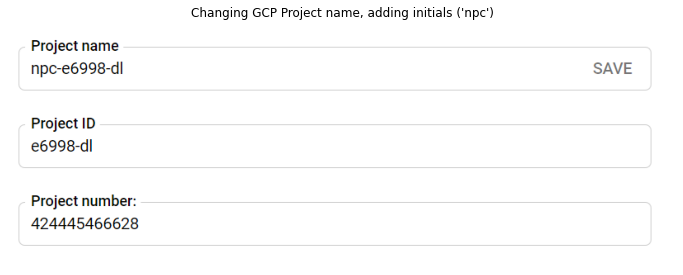

In [78]:
inlineImage('content/q3-1_1_added-initials-to-project-name.PNG',
            title='Changing GCP Project name, adding initials (\'npc\')',
            size=(12,12))

#### 3.1(b) Install MiniKF and deploy your MiniKF instance. {-}  

Following the [Kubeflow MiniKF tutorial](https://codelabs.developers.google.com/codelabs/cloud-kubeflow-minikf-kale), we first install and deploy the VM instance. This step was fairly straightforward, but did require one extra step that was not covered in the tutorial. In ordered to successfully deploy the MiniKF instance, you need to increase your `SSD_TOTAL_GB` (compute.googleapis.com/ssd_total_storage) quota limit for the Zone you choose during the MiniKF configuration (e.g., 'us-west2-b' below). Quotas are now in the GCP Dashboard > Admin > Quotas. Setting to 1000 GB seem to do the trick!

As shown below, I was able to configure the instance by following the tutorial and then successfully deploy the instance. 

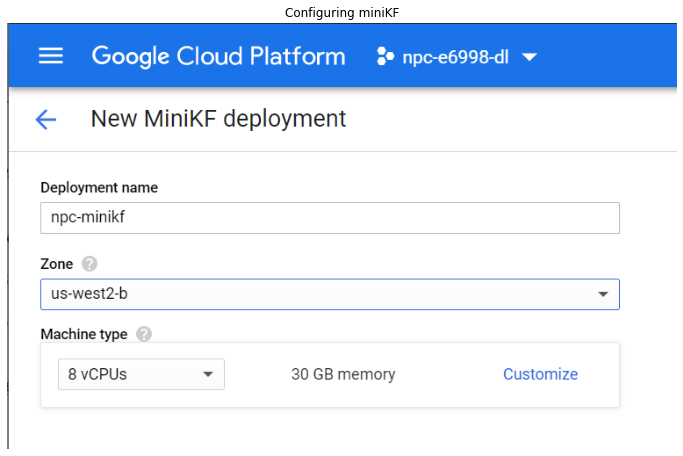

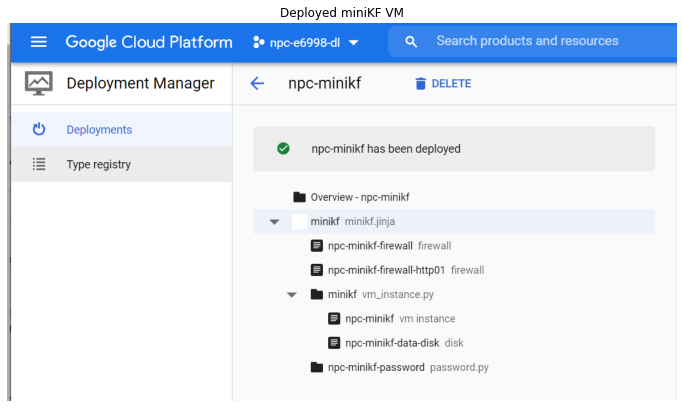

In [117]:
inlineImage('content/q3-1_2_configure-miniKF.PNG',
            title='Configuring miniKF',
            size=(12,12))
inlineImage('content/q3-1_3_deploy-miniKF.PNG',
            title='Deployed miniKF VM',
            size=(12,12))

The next step was to install MiniKf. To accomplish this you SSH into the VM instance (refer to the next section for an image showing how to SSH) and then execute the `minikf` command as shown in the first image. After several minutes, MiniKF is installed and configured and we are presented with a username and password for accessing our MiniKF instance. This is shown in the subsequent images.

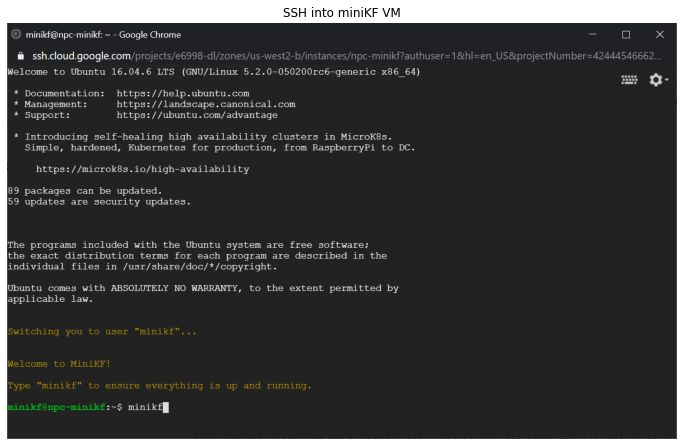

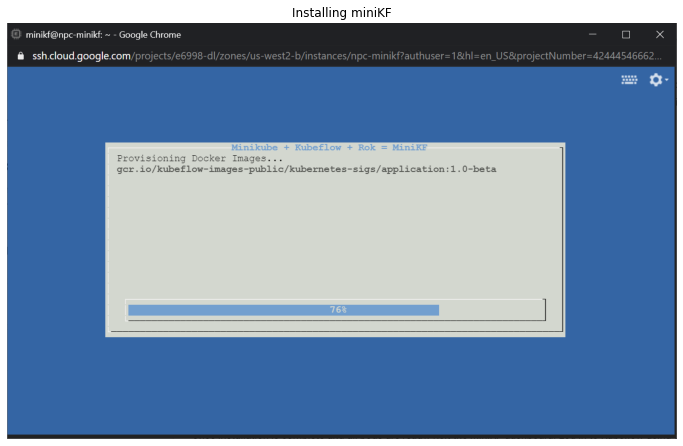

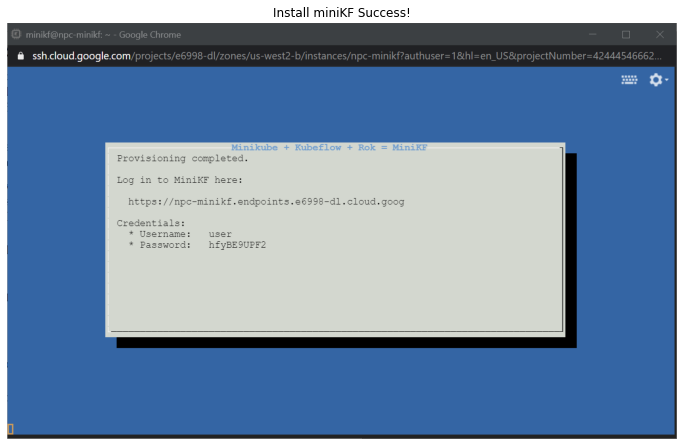

In [118]:
inlineImage('content/q3-1_5_install_miniKF.PNG',
            title='SSH into miniKF VM',
            size=(12,12))
inlineImage('content/q3-1_6_install_miniKF-2.PNG',
            title='Installing miniKF',
            size=(12,12))
inlineImage('content/q3-1_7_install_miniKF-3.PNG',
            title='Install miniKF Success!',
            size=(12,12))

#### 3.1(c) Login to MiniKF, Kubeflow, and Rok.   

The next step is to log into Kubeflow using the username an password provided at the end of the MiniKF installation (refer to the image above). To access Kubeflow, folloe the link provided under the GCP image deployment details (shown below as "MiniKF dashboard." Finally, we must log into Rok (which did not require a username and password). The images below illustrate these steps.

_Note 1: below you will see the login pages/portals for MiniKF and Kubeflow (respectively) followed by what appears to be the Rok interface. When following the tutorial, I was not presented with a login screen to Rok but instead it seems to have automatically logged me in._   
_Note 2: the installation section above shows me logged into MiniKF terminal to install MiniKF._

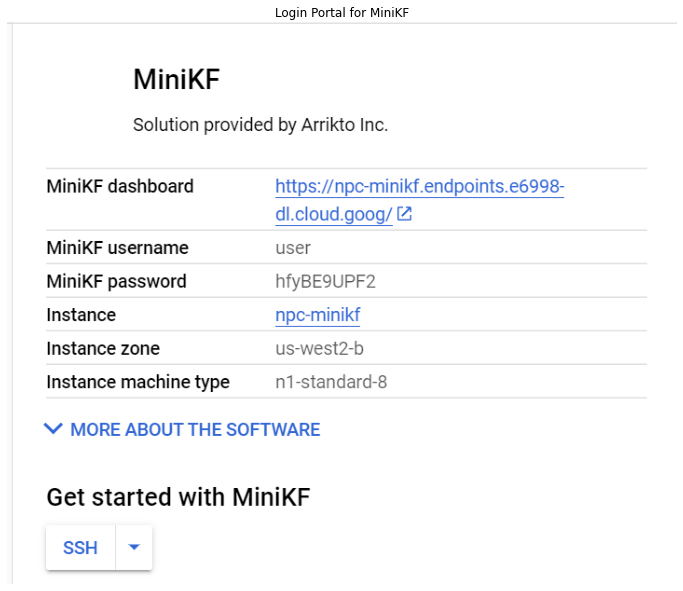

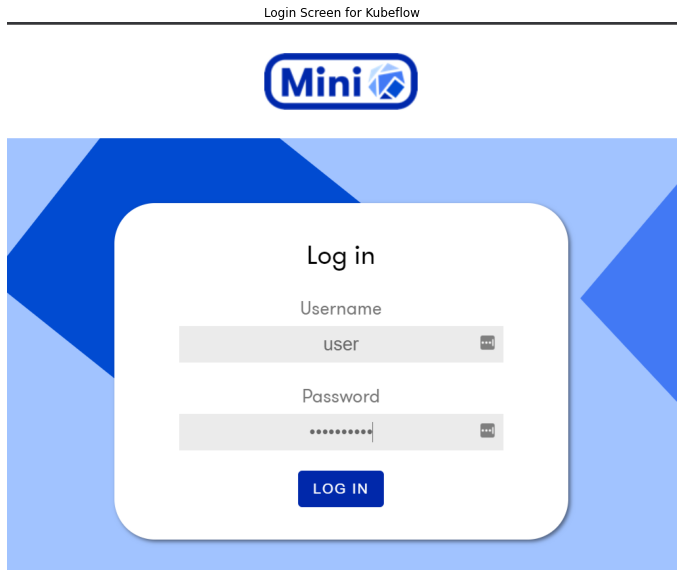

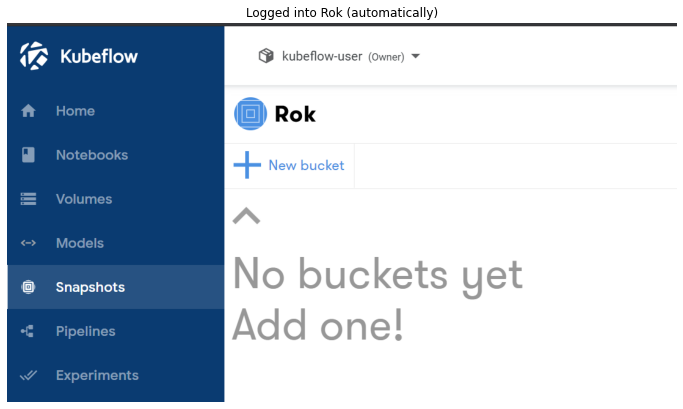

In [81]:
inlineImage('content/q3-1_8_login-miniKF-1.PNG',
            title='Login Portal for MiniKF',
            size=(12,12))
inlineImage('content/q3-1_9_login-Kubeflow-1.PNG',
            title='Login Screen for Kubeflow',
            size=(12,12))
inlineImage('content/q3-1_10_login-Rok-1.PNG',
            title='Logged into Rok (automatically)',
            size=(12,12))

#### 3.2 Run a Pipeline from inside your Notebook: {-}  

#### 3.2(a) Create a notebook server. {-}   

Now we can create a Jupyter notebook server. Per Piazza @364, we have to use the most recent [jupyter-kale docker image](https://console.cloud.google.com/gcr/images/arrikto/GLOBAL/jupyter-kale@sha256:910b49bfa674f113f47c66d82fceda3291c83fe72e63dec7e28134aac1744bad/details?tab=info) (shown below).

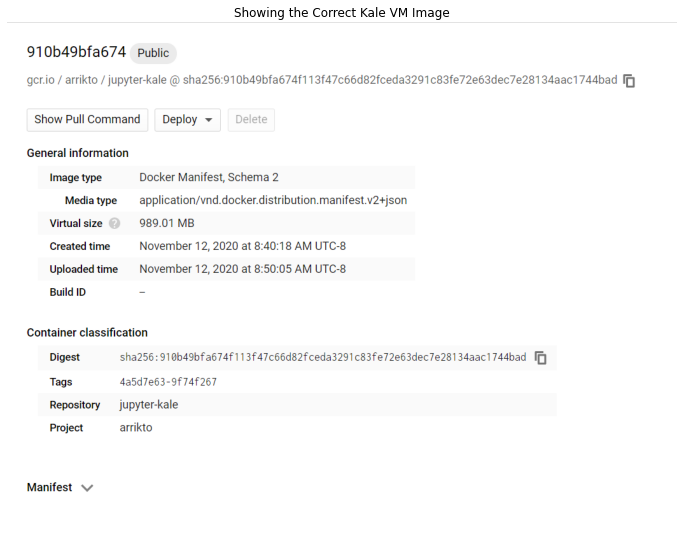

In [82]:
inlineImage('content/q3-2_1_configure-notebook-server-new-image-0.PNG',
            title='Showing the Correct Kale VM Image',
            size=(12,12))

With a link to the correct VM image, we can now spin up the server and configure the environment.

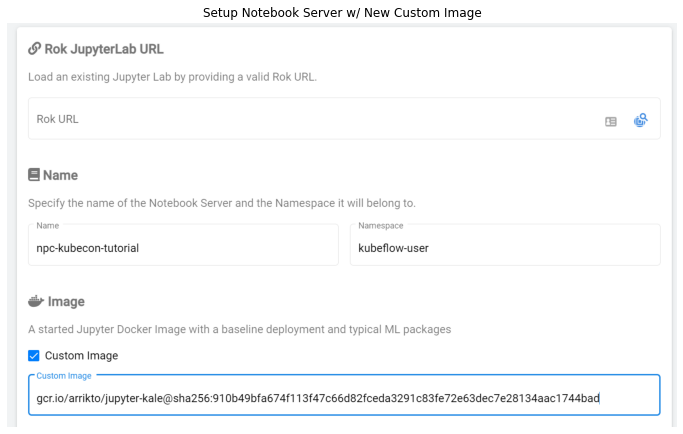

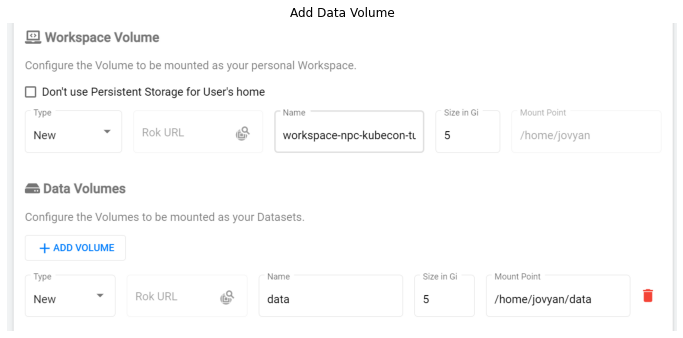

In [83]:
inlineImage('content/q3-2_1_configure-notebook-server-new-image-1.PNG',
            title='Setup Notebook Server w/ New Custom Image',
            size=(12,12))
inlineImage('content/q3-2_1_configure-notebook-server-new-image-2.PNG',
            title='Add Data Volume',
            size=(12,12))

Once the container is deployed, we can see that it is up and running (green check mark) -- SUCCESS!

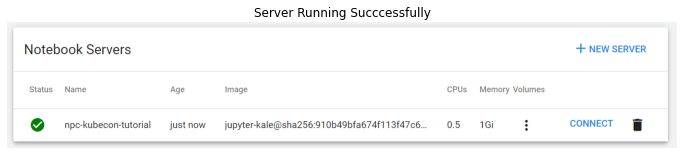

In [84]:
inlineImage('content/q3-2_1_configure-notebook-server-new-image-3.PNG',
            title='Server Running Succcessfully',
            size=(12,12))

#### 3.2(b) Download and run the notebook: {-}
* We will be using `pytorch-classification` notbeook from the example repo.   

The `pytorch-classification` notebook was cloned per the tutorial; however, when first attempting to run the notebook (not shown) it became immediately obvious that the container did not have Pytorch installed (first Jupyter cell failed to import `torch`); as such, pytorch+cpu and dependencies was installed following the instructions on the [PyTorch](https://pytorch.org/get-started/locally/) website.

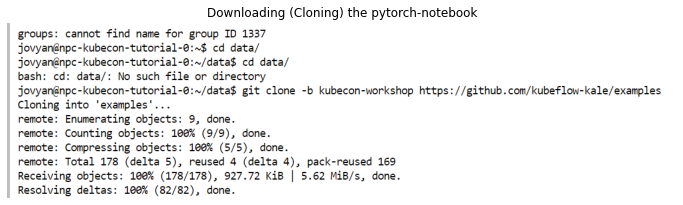

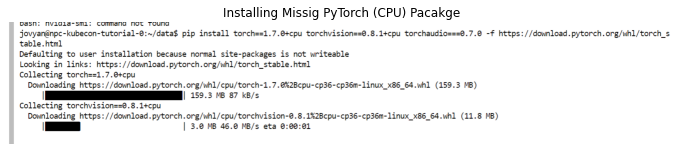

In [86]:
inlineImage('content/q3-2_2_pytorch-classification-notebook-0.PNG',
            title='Downloading (Cloning) the pytorch-notebook',
            size=(12,12))
inlineImage('content/q3-2_3_pytorch-cpu-installation.PNG',
            title='Installing Missig PyTorch (CPU) Pacakge',
            size=(12,12))

With the `pytorch-classification` downloaded and dependencies installed, I was able to run through the entire notebook without issue. The images below show several snippets of the notebook running (some detail left out for brevity). 

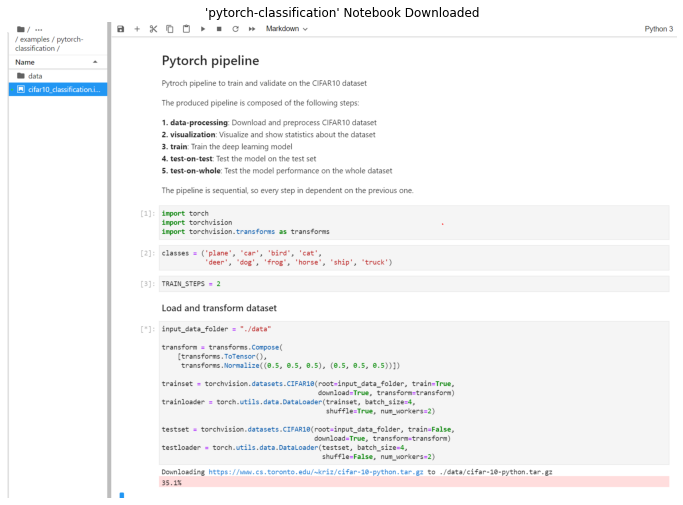

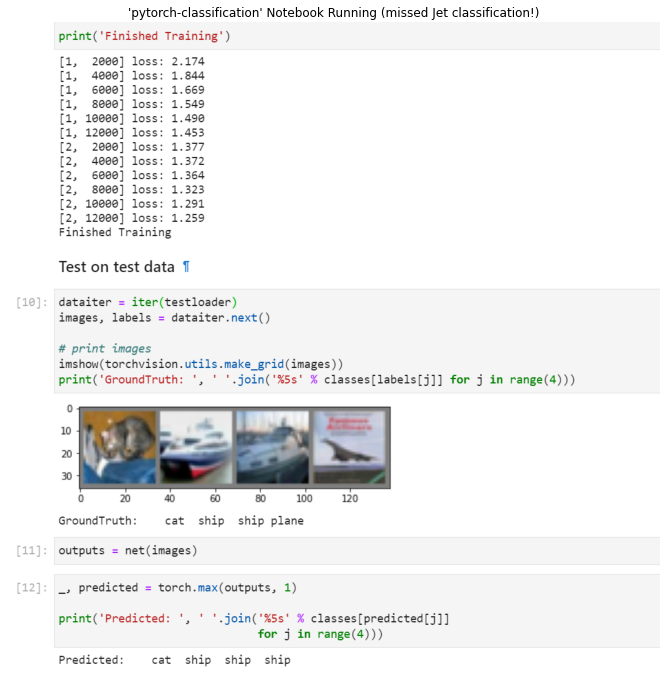

In [88]:

inlineImage('content/q3-2_2_pytorch-classification-notebook-1.PNG',
            title='\'pytorch-classification\' Notebook Downloaded',
            size=(12,12))
inlineImage('content/q3-2_2_pytorch-classification-notebook-2.PNG',
            title='\'pytorch-classification\' Notebook Running (missed Jet classification!)',
            size=(12,12))

#### 3.2(c) Convert your notebook to a Kubeflow Pipeline: 
* Enable Kale and then compile and run the pipeline from Kale Deployment Panel. 
* Show output from each of the 5 steps of the pipeline  

With the `pytorch-classification` notebook confirmed working, I was now able convert the notebook to a Kubeflow pipeline. The first image below shows the Kale configuration -- I named the pipeline `npc-pytorch-pl` and  enabled the deployment panel to trigger the notebook conversion process. In the subsequent images we can see that the contents of the notebook have changed! There is clear indication that the notebook has been converted into a Kubeflow pipeline -- each step of the pipeline is now clearly indicated in the notebook as shown in the images below.

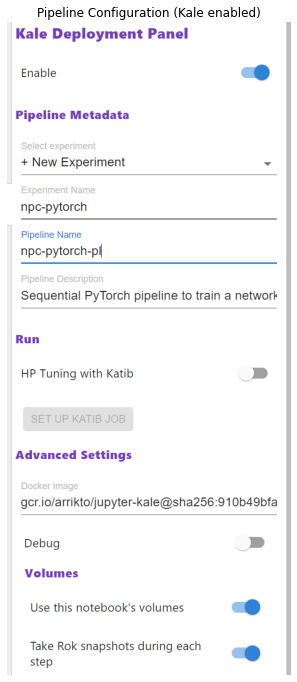

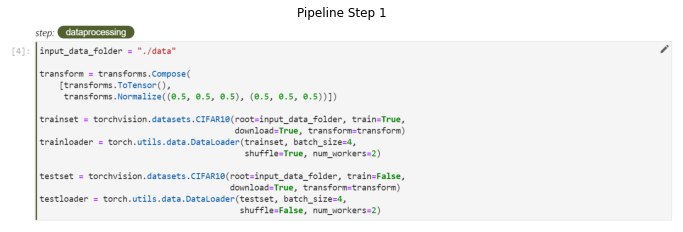

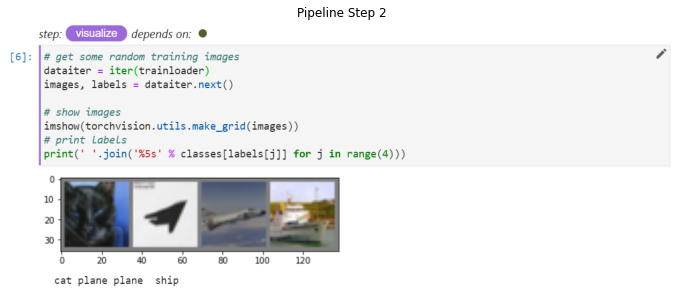

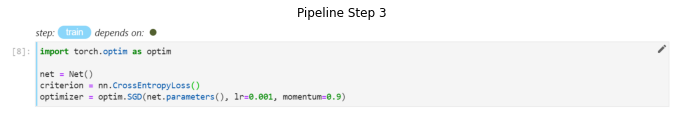

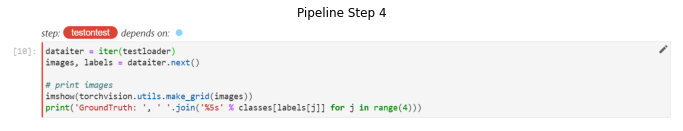

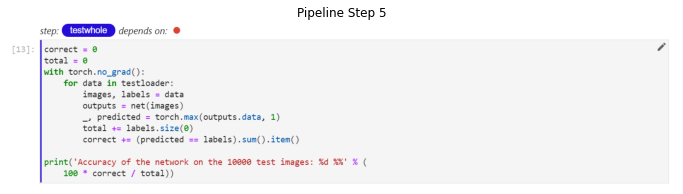

In [89]:
inlineImage('content/q3-2_5_Pipeline-Compile-1.PNG',
            title='Pipeline Configuration (Kale enabled)',
            size=(12,12))
for i in range(1,6):
    inlineImage(f'content/q3-2_4_Pipeline-Step{i}.PNG',
                title=f'Pipeline Step {i}',
                size=(12,12))

After hitting "COMPILE AND RUN" we get the final indication that the notebook was successfully converted to a Kubeflow pipeline and the pipeline was executed.

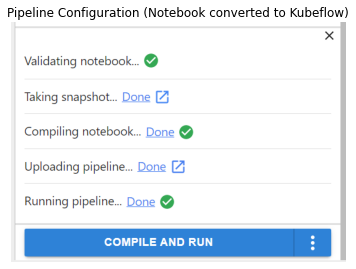

In [90]:
inlineImage('content/q3-2_5_Pipeline-Compile-2.PNG',
            title='Pipeline Configuration (Notebook converted to Kubeflow)',
            size=(6,6))

#### 3.2(d) Show snapshots of "Graph" and "Run output" of the experiment.{-}    

In the image above, we can click on the "Done" hyperlink to navigate to the Kubeflow dashboard. By default I was taken to the Graph tab; however, if you run into issues you can always get there by going to the Kubeflow menu (on the left) selecting "Runs/Trials" and then "Pipelines" -- select the target pipeline from the list and then select the Graph tab. This is illustrated in the two images below.  

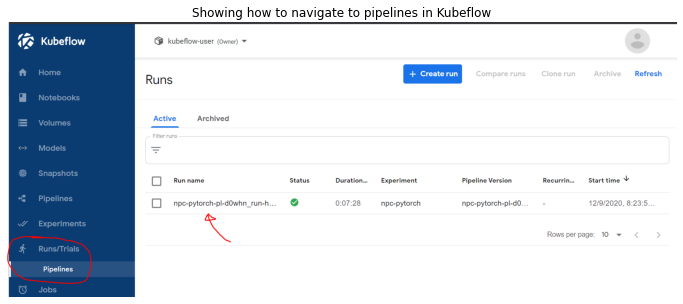

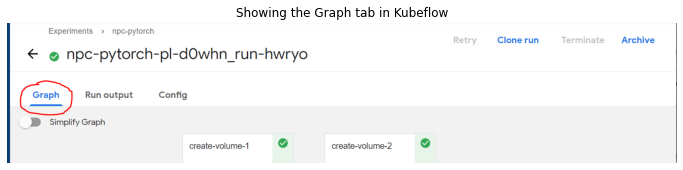

In [91]:
inlineImage('content/q3-2_5_Pipeline-Compile-3.PNG',
            title='Showing how to navigate to pipelines in Kubeflow',
            size=(12,12))
inlineImage('content/q3-2_6_Pipeline-Graph-0.PNG',
            title='Showing the Graph tab in Kubeflow',
            size=(12,12))

Getting back to our pipeline. When the pipeline starts compiling, we can explore the Graph and watch as it is updated as each step of the pipeline is completed. At the beginning of the execution, Rok creates to separate volumes and then starts the `Dataprocessing` pipeline step. This is shown below.

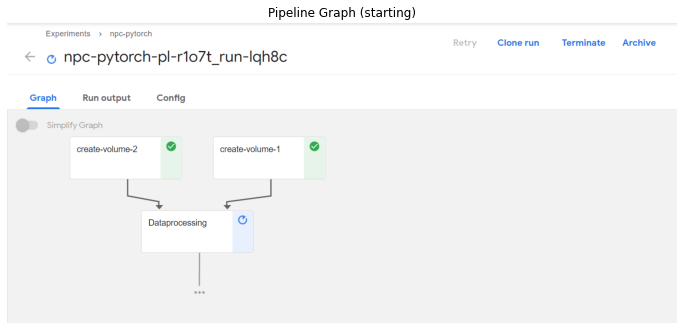

In [93]:
inlineImage('content/q3-2_6_Pipeline-Graph-1.PNG',
            title='Pipeline Graph (starting)',
            size=(12,12))

Midway through the pipeline we can see a good example of how we defined the dependency of each step. Here, we can see that the `Visualize` and `Train` pipeline steps depend on the `Dataprocessing` pipeline step, but `Visualize` does not depend on `Train` (we are just visualizing the input images!).

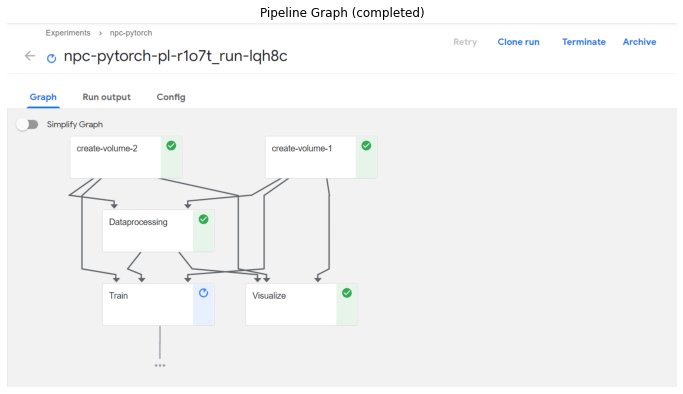

In [94]:
inlineImage('content/q3-2_6_Pipeline-Graph-2.PNG',
            title='Pipeline Graph (completed)',
            size=(12,12))

When the pipeline was ran successfully you should see a green circle/checkmark next to the pipeline name (e.g., `npc-pytorch-l-...`). The final pipeline is shown below.

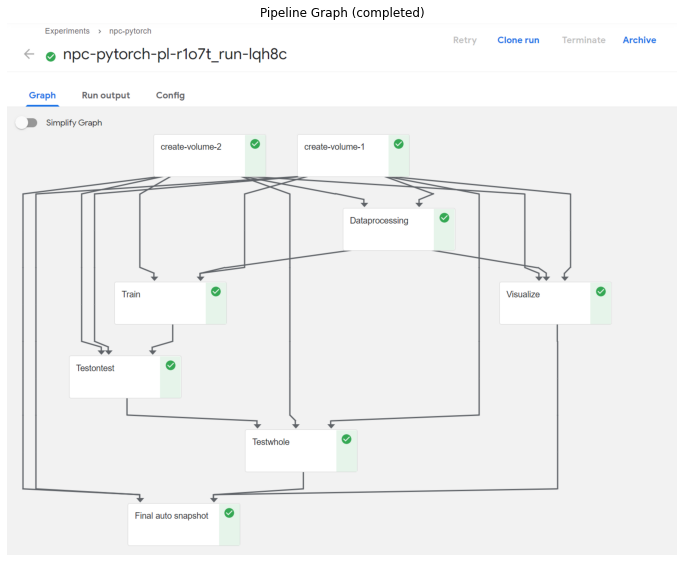

In [95]:
inlineImage('content/q3-2_6_Pipeline-Graph-3.PNG',
            title='Pipeline Graph (completed)',
            size=(12,12))

Finally, the results from the Kubeflow pipeline are presented in the 'Run output' tab within the pipeline details (highlighted below). Results from the `pytorch-notebook` are presented in subsequent images. The output matches what we would expect (based on our initial check to make sure the notebook when run)!

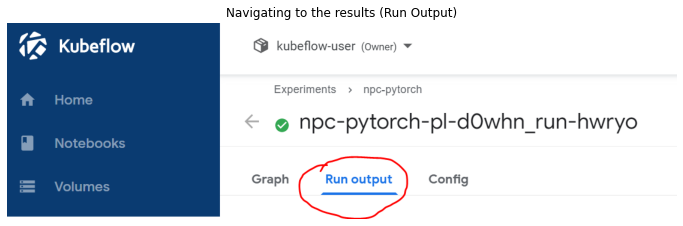

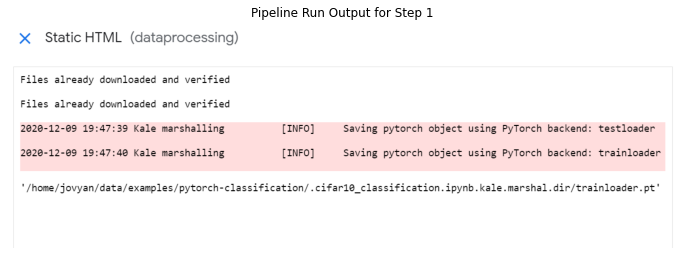

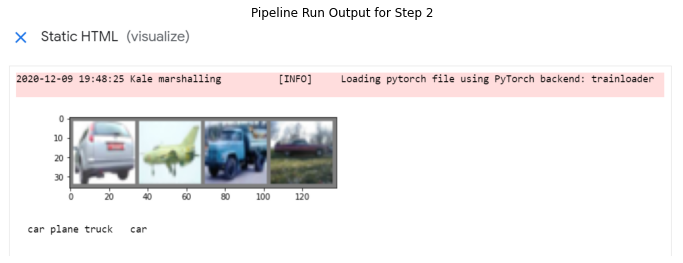

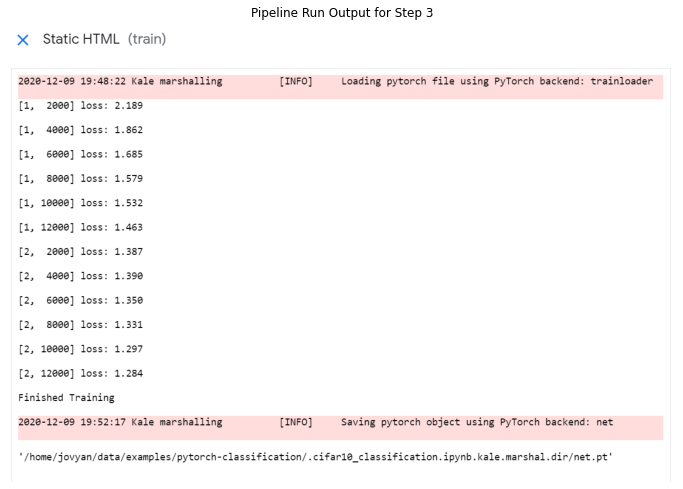

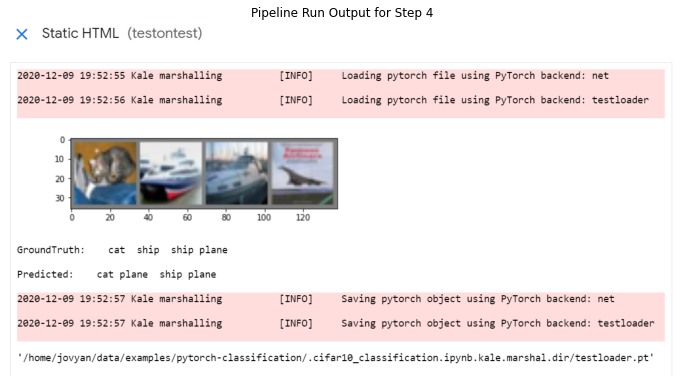

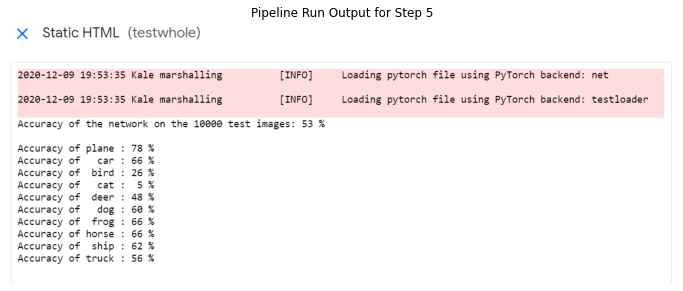

In [97]:
inlineImage('content/q3-2_6_Pipeline-RunOutput-0.PNG',
            title=f'Navigating to the results (Run Output)',
            size=(12,12))
for i in range(1,6):
    inlineImage(f'content/q3-2_6_Pipeline-RunOutput-{i}.PNG',
                title=f'Pipeline Run Output for Step {i}',
                size=(12,12))

#### 3.2(e) Cleanup: Destroy the MiniKF VM.

Finally, we can navigate back to the GCP deployment manager, select the running miniKF deployment, and deleted it

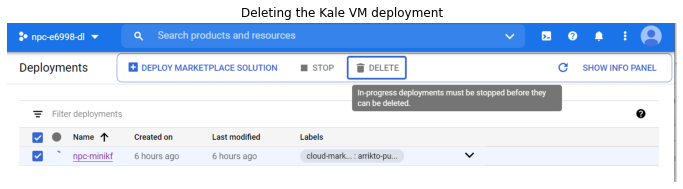

In [98]:
inlineImage('content/q3-2_7_CleanUp-delete-deployment.PNG',
            title=f'Deleting the Kale VM deployment',
            size=(12,12))

__This concludes Problem 3!__

***
## Problem 4 - Deep Reinforcement Learning (20) {-}
This question is based on Deep RL concepts discussed in Lecture 8. You need to refer to the papers by Mnih
et al., Nair et al., and Horgan et al. to answer this question. All papers are linked below.

* Mnih et al. Playing Atari with Deep Reinforcement Learning. 2013 Available at https://arxiv.org/pdf/1312.5602.pdf
* Nair et al. Massively Parallel Methods for Deep Reinforcement Learning. 2015 Available at https://arxiv.org/pdf/1507.04296.pdf
* Horgan et al. Distributed Prioritized Experience Replay. 2018 Available at https://arxiv.org/pdf/1803.00933.pdf

### 4.1 {-}
__Explain the difference between episodic and continuous tasks? Give an example of each.__   

#### Answer:

* Episodic tasks are defined for a finite (time) duration and have an end-state (i.e., there is a state that has a probability of $0$ that the actor can get out of that state)--as mentioned in lecture, most games (e.g., chess, pong, etc.) are examples of episodic tasks.   
* Continuous tasks, on the other hand, have no end-state and the agent is continuously engaging with the environment--a smart home "controller" might be an example of a continuous task (where the smart home has temperature and motion sensors that are continuously monitoring their environment and the smart home "controller" always engaged).

### 4.2 {-}
__What do the terms exploration and exploitation mean in RL? Why do the actors employ $\epsilon$-greedy policy
for selecting actions at each step? Should $\epsilon$ remain fixed or follow a schedule during Deep RL training? How does the value of $\epsilon$ help balance exploration and exploitation during training?__

#### Answer:    

From lecture, we can see that exploration is the term used for actors selecting different actions and "exploring" the different rewards output from the environment--this occurs early on during learning. Exploitation, on the other hand, occurs later in learning when the model has become more confident and is able to exploit the knowledge obtained during exploration (i.e., exploitation chooses actions that have been learned). 

Actors employ $\epsilon$-greedy policy because we want them to explore (i.e., random action at probability of $\epsilon$) while also exploiting their knowledge (i.e., choosing a learned action at probability of $1-\epsilon$).

Ideally we want a scheduled decay of $\epsilon$ to a certain point so that as they exploit their knowledge more often as they learn the space and gain confidence. This helps to balance exploration and exploitation.

### 4.3 {-} 
__How is the Deep Q-Learning algorithm different from Q-learning ? You will follow the steps of Deep
Q-Learning algorithm in Mnih et al. (2013) page 5, and explain each step in your own words.__

#### Answer:   

Deep Q-learning uses a function approximator (with learnable weights, $\theta$). Below we will walk through the algorithm for Deep Q-learning algorithm.  

> 1 | $\textrm{Initialize replay memory } \mathcal{D} \textrm{ to capacity } N$

Line 1 is trivial; we are simple initializing the replay memory that will be used to store N frames for the experience replay process.

> 2 | $\textrm{Initialize action-value function } \mathcal{Q} \textrm{ with random weights}$

Line 2 is also trivial, we are simply initializing the Q-network weights ($\theta$) prior to learning. _Note: they do not specify a weight initialization schema._  

> 3 | $\textrm{for episode = } 1, M \textrm{do}$   

For Line 3 an episode represents one session of gameplay; we can relate this to an epoch. So let's loop through multiple sessions of game play ($t \rightarrow T$)

> 4 | $\textrm{Initialize sequence } s_{1} = \{x_{1}\} \textrm{ and preprocessed sequenced } \phi_{1} = \phi(s_{1})$  

In Line 4 we are initializing the sequence of actions/observations ($s_{1}$) to be equal to the first input image ($x_{1}$). Also, the preprocessing explained in Section 4.1 is then applied via $\phi$, augmenting the input images to be in the correct format/size.

> 5 | $\textrm{for } t = 1, T \textrm{ do}$

Line 5 we are starting to loop through each time-step ($t$) of the game until the game terminates ($T$).

> 6 | $\textrm{With probability } \epsilon \textrm{ select a random action } a_{t}$    
> 7 | $\textrm{otherwise select } a_{t} = \max_{a} Q^{*}(\phi(s_{t}), a; \theta)$

For Lines 6 and 7 we are applying the $\epsilon$-greedy policy. That is, we either randomly select an action (i.e., game move) or we apply the greedy strategy with a probability of $\epsilon$ or $1-\epsilon$, respectively. 

> 8 | $\textrm{Execute action at in emulator and observe reward } r_{t} \textrm{ and image } x_{t+1}$

Line 8 is trivial; we apply the action ($a_{t}$) from the previous step and observe what happens. That is, what reward ($r_{t}$) did we receive and what does the next image ($x_{t+1}$) look like following the execution of our selected action.

> 9 | $\textrm{Set } s_{t+1} = s_{t}, a_{t}, x_{t+1} \textrm{ and preprocess } \phi_{t+1} = \phi(s_{t+1})$  

Line 9 is essentially a repeat of Line 4; we update the sequence based on the response of Line 8 and we prepare the next set of images by applying the augmentation to get them in the proper format for the network.

> 10| $\textrm{Store transition } (\phi_{t}, a_{t}, r_{t}, \phi_{t+1}) \textrm{ in } \mathcal{D}$

Line 10 stores the result. It includes the current pre-processed image set, the action we chose to execute, the reward we received for the action we executed, and the next pre-processed image set (following our action). 

> 11| $\textrm{Sample random minibatch of transitions } (\phi_{j}, a_{j}, r_{j}, \phi_{j+1}) \textrm{ from } \mathcal{D}$



> 12| $\textrm{Set } y_{j} = \begin{cases} r_{j},& \text{for terminal } \phi_{j+1} \\ r_{j} + \gamma \max_{a'}Q(\phi_{j+1}.a_{j}';\theta), & \text{for non-terminal } \phi_{j+1} \end{cases}$

Line 12 is adhering to the Bellman equation, where we are iteratively updating the optimal action-value. If it is the last set of images then we simply set the output to the reward; otherwise, we set the output to the reward plus a gradually discounted optimal action-value.

> 13| $\textrm{Perform a gradient descent step on } (y_{j} − Q(\phi_{j}; a_{j}; \theta))^{2} \textrm{ according to equation 3}$

Line 13 is minimizing the loss function via gradient descent.

> 14-15| $\textrm{end for}$   

Lines 14 and 15 are the end of the for loops; no description is needed.


### 4.4 {-} 
__What is the benefit of having a target Q-network ?__   

#### Answer
Per Nair et al., the target Q-network allows for the current Q-network parameters $\theta$ to be updated so as to minimize the mean-squared Bellman error with respect to old (target-Q) parameters $\theta^{-}$

### 4.5 {-} 
__How does experience replay help in efficient Q-learning ?__

#### Answer:   

In summary from lecture as well as the references, experience replay

1.  prevents instability because without experience replay the Q-network may get stuck in a poor local minimum or diverge during the stochastic gradient descent process (Mnih et al.)
2. randomizes the samples and breaks the inter-sample correlations (reducing the variance of the updates) (Mnih et al.)
4. allows for reusing the data (i.e., when learning on-policy the current parameters determine the next data sample that the parameters are trained on) (Mnih et al.)
5. may also help to prevent overfitting by allowing the agent to learn from data generated by previous versions of the policy (Horgan et al.)


### 4.6 {-}
__What is prioritized experience replay ?__

#### Answer:   
Prioritized experience replay extends experience replay by encouraging the sampling procedures to be more general such that learning focuses on the most ‘surprising’ experiences. This can be helpful "since the reward signal may be sparse and the data distribution depends on the agent’s policy" (Horgan et al.).


### 4.7 {-}
__Compare and contrast GORILA (General Reinforcement Learning Architecture) and Ape-X architecture. Provide three similarities and three differences.__

#### Answer:   

|Similar | Different|
|--------|----------|
|Multiple Actors (distributed) store experiences|\| Ape-X samples based on priority experience replay|
|Single Learner samples shared experience memory|\| Ape-X uses a shared, centralized memory (vs. uniform sampling)|
|Distributed SGD|\| Gorila uses a sharded parameter server|

__This concludes Problem 4!__   

***